## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


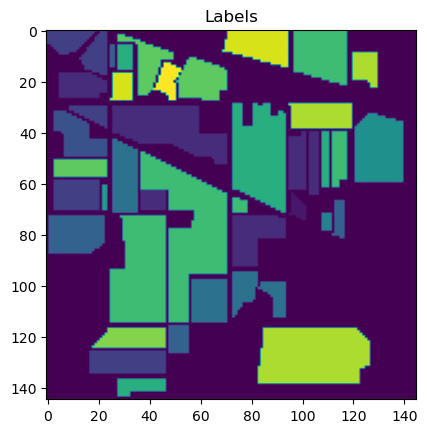

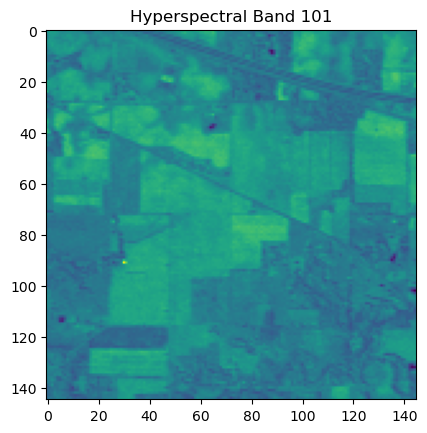

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class '7'
Se


All datasets saved to the 'indices' folder.
(80, 5, 5, 200)
(80, 5, 5, 200)
(10089, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 80
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0784, PSNR: 10.7233


Epoch [1/50] Training Loss: 0.0650, PSNR: 11.4599
	[Val]   Batch [1/33] Loss: 0.0504, PSNR: 12.6435
	[Val]   Batch [10/33] Loss: 0.0496, PSNR: 12.3074
	[Val]   Batch [20/33] Loss: 0.0493, PSNR: 11.9002
	[Val]   Batch [30/33] Loss: 0.0480, PSNR: 12.2605
Epoch [1/50] Validation Loss: 0.0500, PSNR: 12.4670

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0501, PSNR: 12.6624


Epoch [2/50] Training Loss: 0.0399, PSNR: 13.5683
	[Val]   Batch [1/33] Loss: 0.0292, PSNR: 15.0159
	[Val]   Batch [10/33] Loss: 0.0287, PSNR: 14.6940
	[Val]   Batch [20/33] Loss: 0.0284, PSNR: 14.3040
	[Val]   Batch [30/33] Loss: 0.0277, PSNR: 14.6556
Epoch [2/50] Validation Loss: 0.0291, PSNR: 14.8256

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0294, PSNR: 15.0886


Epoch [3/50] Training Loss: 0.0233, PSNR: 15.9195
	[Val]   Batch [1/33] Loss: 0.0178, PSNR: 17.1537
	[Val]   Batch [10/33] Loss: 0.0173, PSNR: 16.8746
	[Val]   Batch [20/33] Loss: 0.0171, PSNR: 16.5089
	[Val]   Batch [30/33] Loss: 0.0166, PSNR: 16.8847
Epoch [3/50] Validation Loss: 0.0177, PSNR: 16.9704

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0172, PSNR: 16.6475


Epoch [4/50] Training Loss: 0.0141, PSNR: 18.0763
	[Val]   Batch [1/33] Loss: 0.0114, PSNR: 19.1041
	[Val]   Batch [10/33] Loss: 0.0109, PSNR: 18.8909
	[Val]   Batch [20/33] Loss: 0.0106, PSNR: 18.5619
	[Val]   Batch [30/33] Loss: 0.0103, PSNR: 18.9518
Epoch [4/50] Validation Loss: 0.0113, PSNR: 18.9335

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0108, PSNR: 19.4553


Epoch [5/50] Training Loss: 0.0093, PSNR: 19.9040
	[Val]   Batch [1/33] Loss: 0.0079, PSNR: 20.6988
	[Val]   Batch [10/33] Loss: 0.0074, PSNR: 20.5714
	[Val]   Batch [20/33] Loss: 0.0072, PSNR: 20.2862
	[Val]   Batch [30/33] Loss: 0.0069, PSNR: 20.6678
Epoch [5/50] Validation Loss: 0.0078, PSNR: 20.5431

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0071, PSNR: 20.9440


Epoch [6/50] Training Loss: 0.0067, PSNR: 21.3072
	[Val]   Batch [1/33] Loss: 0.0060, PSNR: 21.8488
	[Val]   Batch [10/33] Loss: 0.0056, PSNR: 21.8039
	[Val]   Batch [20/33] Loss: 0.0053, PSNR: 21.5634
	[Val]   Batch [30/33] Loss: 0.0051, PSNR: 21.9644
Epoch [6/50] Validation Loss: 0.0060, PSNR: 21.7191

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0056, PSNR: 22.1049


Epoch [7/50] Training Loss: 0.0052, PSNR: 22.4410
	[Val]   Batch [1/33] Loss: 0.0048, PSNR: 22.8838
	[Val]   Batch [10/33] Loss: 0.0043, PSNR: 22.9327
	[Val]   Batch [20/33] Loss: 0.0041, PSNR: 22.7342
	[Val]   Batch [30/33] Loss: 0.0039, PSNR: 23.1423
Epoch [7/50] Validation Loss: 0.0047, PSNR: 22.7846

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0050, PSNR: 22.4602


Epoch [8/50] Training Loss: 0.0042, PSNR: 23.3675
	[Val]   Batch [1/33] Loss: 0.0040, PSNR: 23.6739
	[Val]   Batch [10/33] Loss: 0.0035, PSNR: 23.8188
	[Val]   Batch [20/33] Loss: 0.0033, PSNR: 23.6631
	[Val]   Batch [30/33] Loss: 0.0032, PSNR: 24.0921
Epoch [8/50] Validation Loss: 0.0039, PSNR: 23.6220

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0038, PSNR: 23.7749


Epoch [9/50] Training Loss: 0.0035, PSNR: 24.1144
	[Val]   Batch [1/33] Loss: 0.0033, PSNR: 24.4255
	[Val]   Batch [10/33] Loss: 0.0029, PSNR: 24.6768
	[Val]   Batch [20/33] Loss: 0.0027, PSNR: 24.5711
	[Val]   Batch [30/33] Loss: 0.0025, PSNR: 25.0336
Epoch [9/50] Validation Loss: 0.0032, PSNR: 24.4311

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0028, PSNR: 24.9894


Epoch [10/50] Training Loss: 0.0030, PSNR: 24.7360
	[Val]   Batch [1/33] Loss: 0.0030, PSNR: 24.9500
	[Val]   Batch [10/33] Loss: 0.0025, PSNR: 25.2619
	[Val]   Batch [20/33] Loss: 0.0023, PSNR: 25.1858
	[Val]   Batch [30/33] Loss: 0.0022, PSNR: 25.6584
Epoch [10/50] Validation Loss: 0.0028, PSNR: 24.9795

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0023, PSNR: 26.2002


Epoch [11/50] Training Loss: 0.0027, PSNR: 25.2567
	[Val]   Batch [1/33] Loss: 0.0027, PSNR: 25.3459
	[Val]   Batch [10/33] Loss: 0.0023, PSNR: 25.7079
	[Val]   Batch [20/33] Loss: 0.0021, PSNR: 25.6645
	[Val]   Batch [30/33] Loss: 0.0019, PSNR: 26.1863
Epoch [11/50] Validation Loss: 0.0026, PSNR: 25.4096

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0022, PSNR: 25.9747


Epoch [12/50] Training Loss: 0.0024, PSNR: 25.7266
	[Val]   Batch [1/33] Loss: 0.0023, PSNR: 25.9849
	[Val]   Batch [10/33] Loss: 0.0019, PSNR: 26.3915
	[Val]   Batch [20/33] Loss: 0.0018, PSNR: 26.3780
	[Val]   Batch [30/33] Loss: 0.0016, PSNR: 26.9393
Epoch [12/50] Validation Loss: 0.0022, PSNR: 26.0726

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0034, PSNR: 24.4656


Epoch [13/50] Training Loss: 0.0022, PSNR: 26.1804
	[Val]   Batch [1/33] Loss: 0.0021, PSNR: 26.4712
	[Val]   Batch [10/33] Loss: 0.0017, PSNR: 26.8728
	[Val]   Batch [20/33] Loss: 0.0016, PSNR: 26.8793
	[Val]   Batch [30/33] Loss: 0.0015, PSNR: 27.4267
Epoch [13/50] Validation Loss: 0.0020, PSNR: 26.5469

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0021, PSNR: 26.3911


Epoch [14/50] Training Loss: 0.0020, PSNR: 26.5446
	[Val]   Batch [1/33] Loss: 0.0019, PSNR: 26.7816
	[Val]   Batch [10/33] Loss: 0.0016, PSNR: 27.1428
	[Val]   Batch [20/33] Loss: 0.0015, PSNR: 27.1445
	[Val]   Batch [30/33] Loss: 0.0014, PSNR: 27.7292
Epoch [14/50] Validation Loss: 0.0019, PSNR: 26.8473

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.9254


Epoch [15/50] Training Loss: 0.0019, PSNR: 26.9117
	[Val]   Batch [1/33] Loss: 0.0017, PSNR: 27.4765
	[Val]   Batch [10/33] Loss: 0.0014, PSNR: 27.8234
	[Val]   Batch [20/33] Loss: 0.0013, PSNR: 27.8587
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.4683
Epoch [15/50] Validation Loss: 0.0016, PSNR: 27.5299

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0026, PSNR: 25.4112


Epoch [16/50] Training Loss: 0.0017, PSNR: 27.2844
	[Val]   Batch [1/33] Loss: 0.0015, PSNR: 27.8668
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 28.1700
	[Val]   Batch [20/33] Loss: 0.0012, PSNR: 28.2156
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 28.8638
Epoch [16/50] Validation Loss: 0.0015, PSNR: 27.9016

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 27.8734


Epoch [17/50] Training Loss: 0.0016, PSNR: 27.6629
	[Val]   Batch [1/33] Loss: 0.0013, PSNR: 28.3872
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.6226
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.6967
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.3535
Epoch [17/50] Validation Loss: 0.0013, PSNR: 28.4023

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0018, PSNR: 27.4950


Epoch [18/50] Training Loss: 0.0014, PSNR: 27.9541
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 28.7461
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 28.9626
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.0651
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.7366
Epoch [18/50] Validation Loss: 0.0012, PSNR: 28.7617

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0016, PSNR: 27.5451


Epoch [19/50] Training Loss: 0.0014, PSNR: 28.2673
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.0990
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.2935
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.4354
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 30.0942
Epoch [19/50] Validation Loss: 0.0011, PSNR: 29.1148

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 27.6916


Epoch [20/50] Training Loss: 0.0013, PSNR: 28.5516
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.4317
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.5791
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.7427
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.3875
Epoch [20/50] Validation Loss: 0.0010, PSNR: 29.4247

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 29.3441


Epoch [21/50] Training Loss: 0.0012, PSNR: 28.7621
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.6620
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.8195
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 30.0152
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.6591
Epoch [21/50] Validation Loss: 0.0010, PSNR: 29.6781

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.5542


Epoch [22/50] Training Loss: 0.0012, PSNR: 28.9828
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.7504
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.9045
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.0854
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.8017
Epoch [22/50] Validation Loss: 0.0009, PSNR: 29.7907

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.3788


Epoch [23/50] Training Loss: 0.0011, PSNR: 29.1721
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.1184
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.2824
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.5214
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.2749
Epoch [23/50] Validation Loss: 0.0009, PSNR: 30.1806

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.9869


Epoch [24/50] Training Loss: 0.0011, PSNR: 29.3075
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.3142
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.4651
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.7240
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.4625
Epoch [24/50] Validation Loss: 0.0008, PSNR: 30.3751

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.9920


Epoch [25/50] Training Loss: 0.0010, PSNR: 29.4741
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.5370
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.6685
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.9518
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.7154
Epoch [25/50] Validation Loss: 0.0008, PSNR: 30.5919

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.9210


Epoch [26/50] Training Loss: 0.0010, PSNR: 29.5377
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.4966
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.6323
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.9036
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.5761
Epoch [26/50] Validation Loss: 0.0008, PSNR: 30.5396
Early stopping triggered at epoch 26. No improvement for 3 epochs.


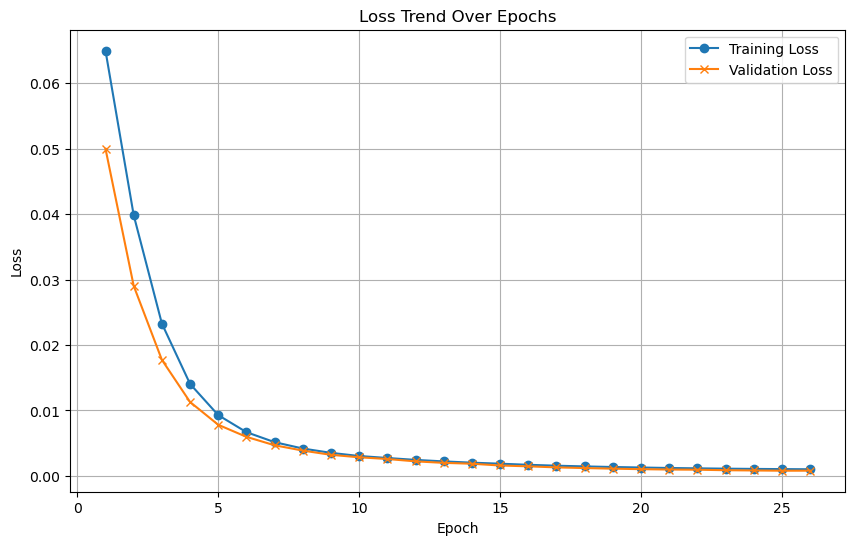

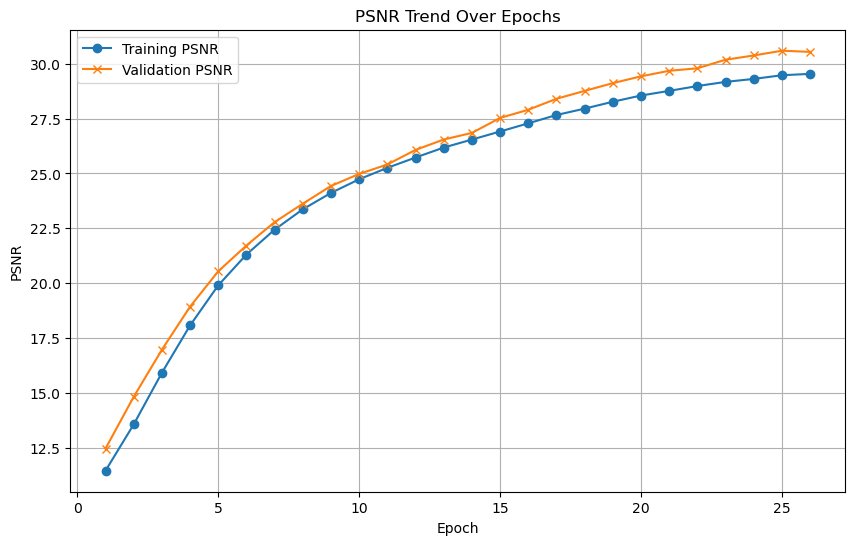

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/40 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.8139
    Validation Batch [1/1], Loss: 2.7808
Validation Loss: 2.7808, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7808. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7593
    Validation Batch [1/1], Loss: 2.7808
Validation Loss: 2.7808, Validation Accuracy: 6.25%
Validation loss improved from 2.7808 to 2.7808. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7470
    Validation Batch [1/1], Loss: 2.7808
Validation Loss: 2.7808, Validation Accuracy: 6.25%
Validation loss improved from 2.7808 to 2.7808. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7288
    Validation Batch [1/1], Loss: 2.7807
Validation Loss: 2.7807, Validation Accuracy: 6.25%
Validation loss improved from 2.7808 to 2.7807. Saving model...

LOG: Epoch [5/1000] - 

Epoch [11/1000] completed, Average Training Loss: 2.6470
    Validation Batch [1/1], Loss: 2.7804
Validation Loss: 2.7804, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.6112
    Validation Batch [1/1], Loss: 2.7804
Validation Loss: 2.7804, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [13/1000] - Training
Epoch [13/1000] completed, Average Training Loss: 2.6243
    Validation Batch [1/1], Loss: 2.7805
Validation Loss: 2.7805, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [14/1000] - Training
Epoch [14/1000] completed, Average Training Loss: 2.5975
    Validation Batch [1/1], Loss: 2.7805
Validation Loss: 2.7805, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [15/1000] - Training
Epoch [15/1000] completed, Average Training Loss: 2.5969
    Validation 

Epoch [22/1000] completed, Average Training Loss: 2.5225
    Validation Batch [1/1], Loss: 2.7797
Validation Loss: 2.7797, Validation Accuracy: 6.25%
Validation loss improved from 2.7802 to 2.7797. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.5123
    Validation Batch [1/1], Loss: 2.7791
Validation Loss: 2.7791, Validation Accuracy: 6.25%
Validation loss improved from 2.7797 to 2.7791. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.5171
    Validation Batch [1/1], Loss: 2.7783
Validation Loss: 2.7783, Validation Accuracy: 11.25%
Validation loss improved from 2.7791 to 2.7783. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.5163
    Validation Batch [1/1], Loss: 2.7775
Validation Loss: 2.7775, Validation Accuracy: 12.50%
Validation loss improved from 2.7783 to 2.7775. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/

    Validation Batch [1/1], Loss: 2.7264
Validation Loss: 2.7264, Validation Accuracy: 6.25%
Validation loss improved from 2.7329 to 2.7264. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.3451
    Validation Batch [1/1], Loss: 2.7182
Validation Loss: 2.7182, Validation Accuracy: 6.25%
Validation loss improved from 2.7264 to 2.7182. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 2.3265
    Validation Batch [1/1], Loss: 2.7074
Validation Loss: 2.7074, Validation Accuracy: 6.25%
Validation loss improved from 2.7182 to 2.7074. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 2.3260
    Validation Batch [1/1], Loss: 2.6975
Validation Loss: 2.6975, Validation Accuracy: 6.25%
Validation loss improved from 2.7074 to 2.6975. Saving model...

LOG: Epoch [45/1000] - Training
Epoch [45/1000] completed, Average Training Loss: 2.3467
    Validati

Epoch [52/1000] completed, Average Training Loss: 2.2922
    Validation Batch [1/1], Loss: 2.6061
Validation Loss: 2.6061, Validation Accuracy: 12.50%
Validation loss improved from 2.6204 to 2.6061. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 2.2570
    Validation Batch [1/1], Loss: 2.5926
Validation Loss: 2.5926, Validation Accuracy: 12.50%
Validation loss improved from 2.6061 to 2.5926. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 2.2640
    Validation Batch [1/1], Loss: 2.5814
Validation Loss: 2.5814, Validation Accuracy: 13.75%
Validation loss improved from 2.5926 to 2.5814. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 2.2637
    Validation Batch [1/1], Loss: 2.5708
Validation Loss: 2.5708, Validation Accuracy: 13.75%
Validation loss improved from 2.5814 to 2.5708. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [5

Epoch [68/1000] completed, Average Training Loss: 2.1325
    Validation Batch [1/1], Loss: 2.4219
Validation Loss: 2.4219, Validation Accuracy: 23.75%
Validation loss improved from 2.4273 to 2.4219. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 2.1073
    Validation Batch [1/1], Loss: 2.4193
Validation Loss: 2.4193, Validation Accuracy: 25.00%
Validation loss improved from 2.4219 to 2.4193. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 2.1207
    Validation Batch [1/1], Loss: 2.4113
Validation Loss: 2.4113, Validation Accuracy: 25.00%
Validation loss improved from 2.4193 to 2.4113. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 2.0774
    Validation Batch [1/1], Loss: 2.4048
Validation Loss: 2.4048, Validation Accuracy: 27.50%
Validation loss improved from 2.4113 to 2.4048. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [7

Epoch [80/1000] completed, Average Training Loss: 2.0289
    Validation Batch [1/1], Loss: 2.3563
Validation Loss: 2.3563, Validation Accuracy: 23.75%
Validation loss improved from 2.3726 to 2.3563. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 2.0660
    Validation Batch [1/1], Loss: 2.3464
Validation Loss: 2.3464, Validation Accuracy: 25.00%
Validation loss improved from 2.3563 to 2.3464. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.9959
    Validation Batch [1/1], Loss: 2.3563
Validation Loss: 2.3563, Validation Accuracy: 23.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.9959
    Validation Batch [1/1], Loss: 2.3764
Validation Loss: 2.3764, Validation Accuracy: 20.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Tra

Epoch [97/1000] completed, Average Training Loss: 1.8373
    Validation Batch [1/1], Loss: 2.2555
Validation Loss: 2.2555, Validation Accuracy: 27.50%
Validation loss improved from 2.2613 to 2.2555. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.8629
    Validation Batch [1/1], Loss: 2.2561
Validation Loss: 2.2561, Validation Accuracy: 28.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.8687
    Validation Batch [1/1], Loss: 2.2378
Validation Loss: 2.2378, Validation Accuracy: 28.75%
Validation loss improved from 2.2555 to 2.2378. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.8686
    Validation Batch [1/1], Loss: 2.2483
Validation Loss: 2.2483, Validation Accuracy: 27.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average

Epoch [110/1000] completed, Average Training Loss: 1.8038
    Validation Batch [1/1], Loss: 2.1804
Validation Loss: 2.1804, Validation Accuracy: 32.50%
Validation loss improved from 2.1945 to 2.1804. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.7640
    Validation Batch [1/1], Loss: 2.1992
Validation Loss: 2.1992, Validation Accuracy: 33.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.7622
    Validation Batch [1/1], Loss: 2.2251
Validation Loss: 2.2251, Validation Accuracy: 31.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.7635
    Validation Batch [1/1], Loss: 2.2219
Validation Loss: 2.2219, Validation Accuracy: 30.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training 

Epoch [128/1000] completed, Average Training Loss: 1.6272
    Validation Batch [1/1], Loss: 2.1393
Validation Loss: 2.1393, Validation Accuracy: 33.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Average Training Loss: 1.5656
    Validation Batch [1/1], Loss: 2.1237
Validation Loss: 2.1237, Validation Accuracy: 32.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [130/1000] - Training
Epoch [130/1000] completed, Average Training Loss: 1.5575
    Validation Batch [1/1], Loss: 2.1302
Validation Loss: 2.1302, Validation Accuracy: 36.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 1.5922
    Validation Batch [1/1], Loss: 2.1237
Validation Loss: 2.1237, Validation Accuracy: 40.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 1.5742
  

Epoch [140/1000] completed, Average Training Loss: 1.5138
    Validation Batch [1/1], Loss: 2.0462
Validation Loss: 2.0462, Validation Accuracy: 40.00%
Validation loss improved from 2.0643 to 2.0462. Saving model...

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.5418
    Validation Batch [1/1], Loss: 2.0543
Validation Loss: 2.0543, Validation Accuracy: 42.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.5173
    Validation Batch [1/1], Loss: 2.0785
Validation Loss: 2.0785, Validation Accuracy: 37.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.4890
    Validation Batch [1/1], Loss: 2.1203
Validation Loss: 2.1203, Validation Accuracy: 37.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 2.0179
Validation Loss: 2.0179, Validation Accuracy: 38.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 1.3315
    Validation Batch [1/1], Loss: 1.9676
Validation Loss: 1.9676, Validation Accuracy: 43.75%
Validation loss improved from 2.0015 to 1.9676. Saving model...

LOG: Epoch [160/1000] - Training
Epoch [160/1000] completed, Average Training Loss: 1.3462
    Validation Batch [1/1], Loss: 1.9540
Validation Loss: 1.9540, Validation Accuracy: 47.50%
Validation loss improved from 1.9676 to 1.9540. Saving model...

LOG: Epoch [161/1000] - Training
Epoch [161/1000] completed, Average Training Loss: 1.3154
    Validation Batch [1/1], Loss: 2.0008
Validation Loss: 2.0008, Validation Accuracy: 50.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 1.3457
    Validation Batch [1/1], Lo

Epoch [170/1000] completed, Average Training Loss: 1.2984
    Validation Batch [1/1], Loss: 1.9475
Validation Loss: 1.9475, Validation Accuracy: 43.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 1.2535
    Validation Batch [1/1], Loss: 1.9528
Validation Loss: 1.9528, Validation Accuracy: 45.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 1.2352
    Validation Batch [1/1], Loss: 1.9758
Validation Loss: 1.9758, Validation Accuracy: 41.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 1.2362
    Validation Batch [1/1], Loss: 1.9487
Validation Loss: 1.9487, Validation Accuracy: 42.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 1.2104
  

    Validation Batch [1/1], Loss: 1.8337
Validation Loss: 1.8337, Validation Accuracy: 51.25%
Validation loss improved from 1.8547 to 1.8337. Saving model...

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 1.0753
    Validation Batch [1/1], Loss: 1.8257
Validation Loss: 1.8257, Validation Accuracy: 52.50%
Validation loss improved from 1.8337 to 1.8257. Saving model...

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 1.0882
    Validation Batch [1/1], Loss: 1.8263
Validation Loss: 1.8263, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 1.1494
    Validation Batch [1/1], Loss: 1.8569
Validation Loss: 1.8569, Validation Accuracy: 47.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 1.1374
    Validation Batch [1/1], Lo

Epoch [200/1000] completed, Average Training Loss: 1.0480
    Validation Batch [1/1], Loss: 1.8413
Validation Loss: 1.8413, Validation Accuracy: 48.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 1.0093
    Validation Batch [1/1], Loss: 1.8645
Validation Loss: 1.8645, Validation Accuracy: 48.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 1.0410
    Validation Batch [1/1], Loss: 1.8770
Validation Loss: 1.8770, Validation Accuracy: 47.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 1.0188
    Validation Batch [1/1], Loss: 1.8877
Validation Loss: 1.8877, Validation Accuracy: 43.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.9716
  

    Validation Batch [1/1], Loss: 1.7704
Validation Loss: 1.7704, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.8705
    Validation Batch [1/1], Loss: 1.7545
Validation Loss: 1.7545, Validation Accuracy: 50.00%
Validation loss improved from 1.7669 to 1.7545. Saving model...

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.8841
    Validation Batch [1/1], Loss: 1.7513
Validation Loss: 1.7513, Validation Accuracy: 52.50%
Validation loss improved from 1.7545 to 1.7513. Saving model...

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.8429
    Validation Batch [1/1], Loss: 1.7406
Validation Loss: 1.7406, Validation Accuracy: 52.50%
Validation loss improved from 1.7513 to 1.7406. Saving model...

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.8541
    Validation 

Epoch [229/1000] completed, Average Training Loss: 0.8250
    Validation Batch [1/1], Loss: 1.7349
Validation Loss: 1.7349, Validation Accuracy: 53.75%
Validation loss improved from 1.7406 to 1.7349. Saving model...

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.8086
    Validation Batch [1/1], Loss: 1.7252
Validation Loss: 1.7252, Validation Accuracy: 55.00%
Validation loss improved from 1.7349 to 1.7252. Saving model...

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.8502
    Validation Batch [1/1], Loss: 1.7308
Validation Loss: 1.7308, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.7910
    Validation Batch [1/1], Loss: 1.7035
Validation Loss: 1.7035, Validation Accuracy: 52.50%
Validation loss improved from 1.7252 to 1.7035. Saving model...

LOG: Epoch [233/1000] - Training
Epoch [233/1000

Epoch [248/1000] completed, Average Training Loss: 0.7193
    Validation Batch [1/1], Loss: 1.6948
Validation Loss: 1.6948, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.6891
    Validation Batch [1/1], Loss: 1.6829
Validation Loss: 1.6829, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.6695
    Validation Batch [1/1], Loss: 1.6627
Validation Loss: 1.6627, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.7133
    Validation Batch [1/1], Loss: 1.6601
Validation Loss: 1.6601, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.6775
  

Epoch [259/1000] completed, Average Training Loss: 0.6027
    Validation Batch [1/1], Loss: 1.6430
Validation Loss: 1.6430, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.6063
    Validation Batch [1/1], Loss: 1.6904
Validation Loss: 1.6904, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.6915
    Validation Batch [1/1], Loss: 1.6729
Validation Loss: 1.6729, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.6721
    Validation Batch [1/1], Loss: 1.6593
Validation Loss: 1.6593, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Training Loss: 0.5545
  

Epoch [279/1000] completed, Average Training Loss: 0.5674
    Validation Batch [1/1], Loss: 1.5860
Validation Loss: 1.5860, Validation Accuracy: 57.50%
Validation loss improved from 1.6092 to 1.5860. Saving model...

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.5676
    Validation Batch [1/1], Loss: 1.5923
Validation Loss: 1.5923, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.6014
    Validation Batch [1/1], Loss: 1.6093
Validation Loss: 1.6093, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.5027
    Validation Batch [1/1], Loss: 1.6333
Validation Loss: 1.6333, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training 

Epoch [289/1000] completed, Average Training Loss: 0.4659
    Validation Batch [1/1], Loss: 1.6911
Validation Loss: 1.6911, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.5012
    Validation Batch [1/1], Loss: 1.6753
Validation Loss: 1.6753, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.4769
    Validation Batch [1/1], Loss: 1.6450
Validation Loss: 1.6450, Validation Accuracy: 48.75%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.4668
    Validation Batch [1/1], Loss: 1.6240
Validation Loss: 1.6240, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.452

Epoch [308/1000] completed, Average Training Loss: 0.4286
    Validation Batch [1/1], Loss: 1.5553
Validation Loss: 1.5553, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.4303
    Validation Batch [1/1], Loss: 1.5705
Validation Loss: 1.5705, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.4299
    Validation Batch [1/1], Loss: 1.5776
Validation Loss: 1.5776, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training Loss: 0.3877
    Validation Batch [1/1], Loss: 1.6147
Validation Loss: 1.6147, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.4307
  

Epoch [319/1000] completed, Average Training Loss: 0.3783
    Validation Batch [1/1], Loss: 1.5717
Validation Loss: 1.5717, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.3819
    Validation Batch [1/1], Loss: 1.5734
Validation Loss: 1.5734, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.3807
    Validation Batch [1/1], Loss: 1.5930
Validation Loss: 1.5930, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.3615
    Validation Batch [1/1], Loss: 1.6183
Validation Loss: 1.6183, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.372

Epoch [336/1000] completed, Average Training Loss: 0.3102
    Validation Batch [1/1], Loss: 1.5240
Validation Loss: 1.5240, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.3474
    Validation Batch [1/1], Loss: 1.4912
Validation Loss: 1.4912, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.3242
    Validation Batch [1/1], Loss: 1.4744
Validation Loss: 1.4744, Validation Accuracy: 61.25%
Validation loss improved from 1.4878 to 1.4744. Saving model...

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.3144
    Validation Batch [1/1], Loss: 1.5550
Validation Loss: 1.5550, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training 

Epoch [351/1000] completed, Average Training Loss: 0.2788
    Validation Batch [1/1], Loss: 1.5175
Validation Loss: 1.5175, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [352/1000] - Training
Epoch [352/1000] completed, Average Training Loss: 0.3183
    Validation Batch [1/1], Loss: 1.4957
Validation Loss: 1.4957, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.3066
    Validation Batch [1/1], Loss: 1.4759
Validation Loss: 1.4759, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.3071
    Validation Batch [1/1], Loss: 1.4597
Validation Loss: 1.4597, Validation Accuracy: 55.00%
Validation loss improved from 1.4744 to 1.4597. Saving model...

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Traini

Epoch [366/1000] completed, Average Training Loss: 0.2705
    Validation Batch [1/1], Loss: 1.4832
Validation Loss: 1.4832, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.2590
    Validation Batch [1/1], Loss: 1.4688
Validation Loss: 1.4688, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.2579
    Validation Batch [1/1], Loss: 1.4569
Validation Loss: 1.4569, Validation Accuracy: 56.25%
Validation loss improved from 1.4580 to 1.4569. Saving model...

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.2538
    Validation Batch [1/1], Loss: 1.4424
Validation Loss: 1.4424, Validation Accuracy: 61.25%
Validation loss improved from 1.4569 to 1.4424. Saving model...

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, 

    Validation Batch [1/1], Loss: 1.4230
Validation Loss: 1.4230, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.2603
    Validation Batch [1/1], Loss: 1.4410
Validation Loss: 1.4410, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.2527
    Validation Batch [1/1], Loss: 1.4683
Validation Loss: 1.4683, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training Loss: 0.2226
    Validation Batch [1/1], Loss: 1.4924
Validation Loss: 1.4924, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.2494
    Validation Batch [1/1], Loss: 1.4737
Validation Loss: 1.

Epoch [394/1000] completed, Average Training Loss: 0.2179
    Validation Batch [1/1], Loss: 1.4334
Validation Loss: 1.4334, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training Loss: 0.2332
    Validation Batch [1/1], Loss: 1.4274
Validation Loss: 1.4274, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training Loss: 0.2004
    Validation Batch [1/1], Loss: 1.4500
Validation Loss: 1.4500, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training Loss: 0.2537
    Validation Batch [1/1], Loss: 1.4985
Validation Loss: 1.4985, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.239

Epoch [410/1000] completed, Average Training Loss: 0.1763
    Validation Batch [1/1], Loss: 1.4799
Validation Loss: 1.4799, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [411/1000] - Training
Epoch [411/1000] completed, Average Training Loss: 0.1777
    Validation Batch [1/1], Loss: 1.4614
Validation Loss: 1.4614, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.1936
    Validation Batch [1/1], Loss: 1.4442
Validation Loss: 1.4442, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.1723
    Validation Batch [1/1], Loss: 1.4590
Validation Loss: 1.4590, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.210

Epoch [421/1000] completed, Average Training Loss: 0.2011
    Validation Batch [1/1], Loss: 1.4976
Validation Loss: 1.4976, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.1651
    Validation Batch [1/1], Loss: 1.5063
Validation Loss: 1.5063, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.1670
    Validation Batch [1/1], Loss: 1.4941
Validation Loss: 1.4941, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1755
    Validation Batch [1/1], Loss: 1.4552
Validation Loss: 1.4552, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.152

    Validation Batch [1/1], Loss: 1.4936
Validation Loss: 1.4936, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.1551
    Validation Batch [1/1], Loss: 1.4702
Validation Loss: 1.4702, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [440/1000] - Training
Epoch [440/1000] completed, Average Training Loss: 0.1503
    Validation Batch [1/1], Loss: 1.5058
Validation Loss: 1.5058, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.1336
    Validation Batch [1/1], Loss: 1.5022
Validation Loss: 1.5022, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.1368
    Validation Batch [1/1], Loss: 1.4724
Validation Loss

Epoch [451/1000] completed, Average Training Loss: 0.1378
    Validation Batch [1/1], Loss: 1.4556
Validation Loss: 1.4556, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.1468
    Validation Batch [1/1], Loss: 1.4437
Validation Loss: 1.4437, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.1410
    Validation Batch [1/1], Loss: 1.4259
Validation Loss: 1.4259, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.1433
    Validation Batch [1/1], Loss: 1.4150
Validation Loss: 1.4150, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.1432
  

    Validation Batch [1/1], Loss: 1.3911
Validation Loss: 1.3911, Validation Accuracy: 60.00%
Validation loss improved from 1.3935 to 1.3911. Saving model...

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.1548
    Validation Batch [1/1], Loss: 1.4133
Validation Loss: 1.4133, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.1145
    Validation Batch [1/1], Loss: 1.4421
Validation Loss: 1.4421, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.1276
    Validation Batch [1/1], Loss: 1.4569
Validation Loss: 1.4569, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.1172
    Validation Batch [1/1], Loss: 1.4907
Vali

Epoch [479/1000] completed, Average Training Loss: 0.1699
    Validation Batch [1/1], Loss: 1.4358
Validation Loss: 1.4358, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [480/1000] - Training
Epoch [480/1000] completed, Average Training Loss: 0.1323
    Validation Batch [1/1], Loss: 1.4534
Validation Loss: 1.4534, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [481/1000] - Training
Epoch [481/1000] completed, Average Training Loss: 0.1286
    Validation Batch [1/1], Loss: 1.4729
Validation Loss: 1.4729, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [482/1000] - Training
Epoch [482/1000] completed, Average Training Loss: 0.1412
    Validation Batch [1/1], Loss: 1.5138
Validation Loss: 1.5138, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [483/1000] - Training
Epoch [483/1000] completed, Average Training Loss: 0.138

Epoch [500/1000] completed, Average Training Loss: 0.1373
    Validation Batch [1/1], Loss: 1.4777
Validation Loss: 1.4777, Validation Accuracy: 50.00%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.1088
    Validation Batch [1/1], Loss: 1.4937
Validation Loss: 1.4937, Validation Accuracy: 50.00%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.1027
    Validation Batch [1/1], Loss: 1.4429
Validation Loss: 1.4429, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.1086
    Validation Batch [1/1], Loss: 1.3972
Validation Loss: 1.3972, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.105

Epoch [511/1000] completed, Average Training Loss: 0.1152
    Validation Batch [1/1], Loss: 1.5214
Validation Loss: 1.5214, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [512/1000] - Training
Epoch [512/1000] completed, Average Training Loss: 0.1023
    Validation Batch [1/1], Loss: 1.5168
Validation Loss: 1.5168, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [513/1000] - Training
Epoch [513/1000] completed, Average Training Loss: 0.1079
    Validation Batch [1/1], Loss: 1.5087
Validation Loss: 1.5087, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.1302
    Validation Batch [1/1], Loss: 1.5339
Validation Loss: 1.5339, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [515/1000] - Training
Epoch [515/1000] completed, Average Training Loss: 0.105

Epoch [530/1000] completed, Average Training Loss: 0.0894
    Validation Batch [1/1], Loss: 1.4185
Validation Loss: 1.4185, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.1027
    Validation Batch [1/1], Loss: 1.4037
Validation Loss: 1.4037, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0771
    Validation Batch [1/1], Loss: 1.3974
Validation Loss: 1.3974, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.0903
    Validation Batch [1/1], Loss: 1.4004
Validation Loss: 1.4004, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.093

    Validation Batch [1/1], Loss: 1.4635
Validation Loss: 1.4635, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [541/1000] - Training
Epoch [541/1000] completed, Average Training Loss: 0.0899
    Validation Batch [1/1], Loss: 1.4345
Validation Loss: 1.4345, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [542/1000] - Training
Epoch [542/1000] completed, Average Training Loss: 0.0899
    Validation Batch [1/1], Loss: 1.4317
Validation Loss: 1.4317, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [543/1000] - Training
Epoch [543/1000] completed, Average Training Loss: 0.0841
    Validation Batch [1/1], Loss: 1.4545
Validation Loss: 1.4545, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.1072
    Validation Batch [1/1], Loss: 1.4598
Validation Loss

    Validation Batch [1/1], Loss: 1.4431
Validation Loss: 1.4431, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [563/1000] - Training
Epoch [563/1000] completed, Average Training Loss: 0.0878
    Validation Batch [1/1], Loss: 1.4656
Validation Loss: 1.4656, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 96/100

LOG: Epoch [564/1000] - Training
Epoch [564/1000] completed, Average Training Loss: 0.0788
    Validation Batch [1/1], Loss: 1.4788
Validation Loss: 1.4788, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [565/1000] - Training
Epoch [565/1000] completed, Average Training Loss: 0.0776
    Validation Batch [1/1], Loss: 1.4821
Validation Loss: 1.4821, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [566/1000] - Training
Epoch [566/1000] completed, Average Training Loss: 0.0964
    Validation Batch [1/1], Loss: 1.4909
Validation Loss

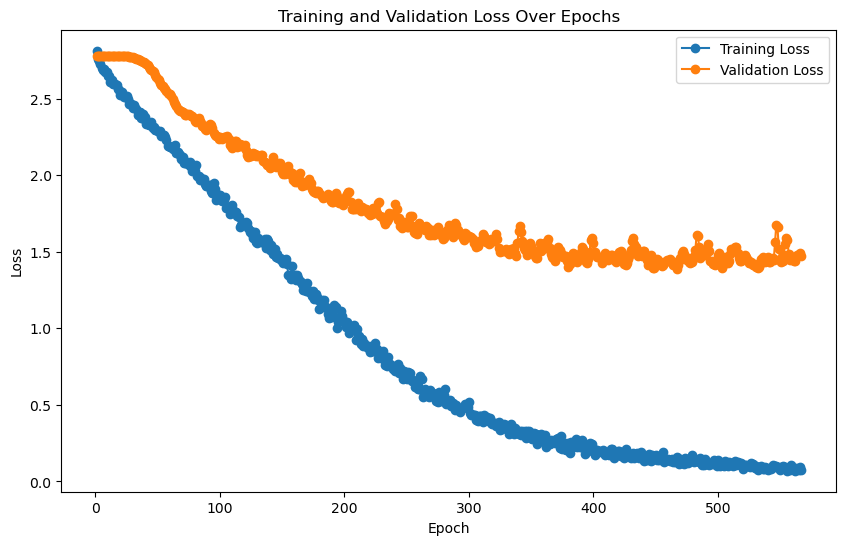

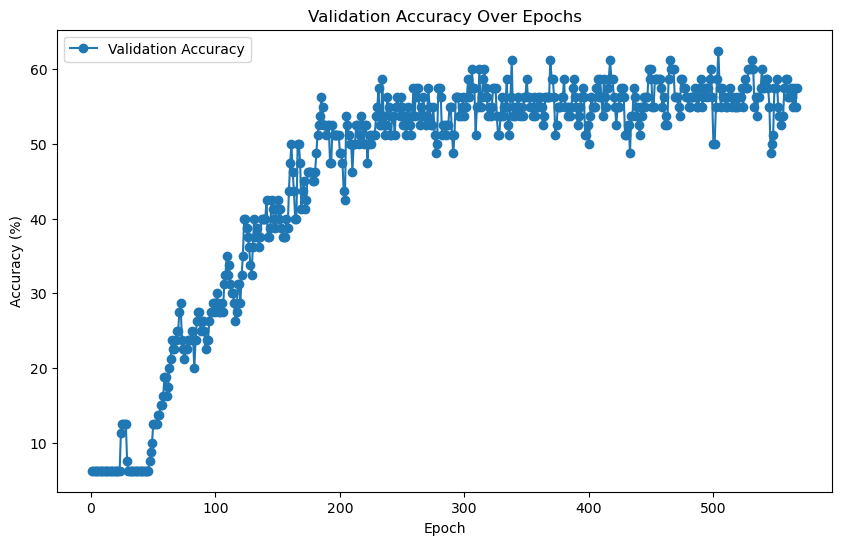


Evaluating on the test set...
    Test Batch [1/40], Loss: 5.2994

Final Test Loss: 1.8012, Test Accuracy: 48.31%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/40 for test dataset.
  Processed batch 20/40 for test dataset.
  Processed batch 30/40 for test dataset.
  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)

LOG: Training features shape: (80, 64), Training labels shape: (80,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (10089, 64), Test labels shape: (10089,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 56.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.50      0.60      0.55         5
           2       0.00      0.00      0.00         5
           3       1.00      0.60      0.75         5
           4       0.80      0.80      0.80         5
           5       0.75      0.60      0.67         5
           6       0.67      0.80      0.73         5
           7       0.43      0.60      0.50         5
           8       1.00      1.00

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)
Train reps shape: (80, 64)
Train labels shape: (80,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (10089, 64)
Test labels shape: (10089,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 3.0258  |  Val Loss: 2.9343
Validation loss improved from inf to 2.9343.
[Epoch 2/1000] Train Loss: 2.8589  |  Val Loss: 2.8459
Validation loss improved from 2.9343 to 2.8459.
[Epoch 3/1000] Train Loss: 2.7730  |  Val Loss: 2.7974
Validation loss improved from 2.8459 to 2.7974.
[Epoch 4/1000] Train Loss: 2.7396  |  Val Loss: 2.7729
Validation loss improved from 2.7974 to 2.7729.
[Epoch 5/1000] Train Loss: 2.7115  |  Val Loss: 2.7477
Validation loss improved from 2.7729 to 2.7477.
[Epoch 6/1000] Train Loss: 2.6792  |  Val Loss: 2.7229
Validation loss improved from 2.7477 to 2.7229.
[Epoch 7/1000] Train Loss: 2.6473  |  Val Loss: 2.7006
Validation loss improved from 2.7229 to 2.7006.
[Epoch 8/1000] Train Loss: 2.6207  |  Val Loss: 2.6833
Validation loss improved from 2.7006 to 2.6833.
[Epoch 9/1000] Train Loss: 2.5963  |  Val Loss: 2.6633
Validation loss improved from 2.6833 to 2.6633.
[Epoch 10/1000] Train Loss: 2.5685  |  Val Loss: 2.6452
Validation loss impr

[Epoch 23/1000] Train Loss: 2.2415  |  Val Loss: 2.3653
Validation loss improved from 2.3907 to 2.3653.
[Epoch 24/1000] Train Loss: 2.2139  |  Val Loss: 2.3462
Validation loss improved from 2.3653 to 2.3462.
[Epoch 25/1000] Train Loss: 2.1953  |  Val Loss: 2.3265
Validation loss improved from 2.3462 to 2.3265.
[Epoch 26/1000] Train Loss: 2.1718  |  Val Loss: 2.3072
Validation loss improved from 2.3265 to 2.3072.
[Epoch 27/1000] Train Loss: 2.1468  |  Val Loss: 2.2887
Validation loss improved from 2.3072 to 2.2887.
[Epoch 28/1000] Train Loss: 2.1177  |  Val Loss: 2.2644
Validation loss improved from 2.2887 to 2.2644.
[Epoch 29/1000] Train Loss: 2.0889  |  Val Loss: 2.2399
Validation loss improved from 2.2644 to 2.2399.
[Epoch 30/1000] Train Loss: 2.0597  |  Val Loss: 2.2182
Validation loss improved from 2.2399 to 2.2182.


[Epoch 31/1000] Train Loss: 2.0319  |  Val Loss: 2.1992
Validation loss improved from 2.2182 to 2.1992.
[Epoch 32/1000] Train Loss: 2.0035  |  Val Loss: 2.1879
Validation loss improved from 2.1992 to 2.1879.
[Epoch 33/1000] Train Loss: 1.9730  |  Val Loss: 2.1843
Validation loss improved from 2.1879 to 2.1843.
[Epoch 34/1000] Train Loss: 1.9570  |  Val Loss: 2.1684
Validation loss improved from 2.1843 to 2.1684.
[Epoch 35/1000] Train Loss: 1.9372  |  Val Loss: 2.1295
Validation loss improved from 2.1684 to 2.1295.
[Epoch 36/1000] Train Loss: 1.9019  |  Val Loss: 2.0846
Validation loss improved from 2.1295 to 2.0846.
[Epoch 37/1000] Train Loss: 1.8725  |  Val Loss: 2.0507
Validation loss improved from 2.0846 to 2.0507.


[Epoch 38/1000] Train Loss: 1.8443  |  Val Loss: 2.0320
Validation loss improved from 2.0507 to 2.0320.
[Epoch 39/1000] Train Loss: 1.8147  |  Val Loss: 2.0217
Validation loss improved from 2.0320 to 2.0217.
[Epoch 40/1000] Train Loss: 1.7877  |  Val Loss: 2.0106
Validation loss improved from 2.0217 to 2.0106.
[Epoch 41/1000] Train Loss: 1.7577  |  Val Loss: 2.0011
Validation loss improved from 2.0106 to 2.0011.
[Epoch 42/1000] Train Loss: 1.7283  |  Val Loss: 2.0000
Validation loss improved from 2.0011 to 2.0000.
[Epoch 43/1000] Train Loss: 1.7063  |  Val Loss: 1.9952
Validation loss improved from 2.0000 to 1.9952.
[Epoch 44/1000] Train Loss: 1.6782  |  Val Loss: 1.9841
Validation loss improved from 1.9952 to 1.9841.
[Epoch 45/1000] Train Loss: 1.6590  |  Val Loss: 1.9615
Validation loss improved from 1.9841 to 1.9615.
[Epoch 46/1000] Train Loss: 1.6339  |  Val Loss: 1.9244
Validation loss improved from 1.9615 to 1.9244.
[Epoch 47/1000] Train Loss: 1.6101  |  Val Loss: 1.8858
Validati

[Epoch 63/1000] Train Loss: 1.2739  |  Val Loss: 1.7558
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 64/1000] Train Loss: 1.2599  |  Val Loss: 1.7656
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 65/1000] Train Loss: 1.2482  |  Val Loss: 1.7503
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 66/1000] Train Loss: 1.2243  |  Val Loss: 1.7091
Validation loss improved from 1.7199 to 1.7091.
[Epoch 67/1000] Train Loss: 1.2072  |  Val Loss: 1.6633
Validation loss improved from 1.7091 to 1.6633.
[Epoch 68/1000] Train Loss: 1.2002  |  Val Loss: 1.6393
Validation loss improved from 1.6633 to 1.6393.
[Epoch 69/1000] Train Loss: 1.1960  |  Val Loss: 1.6373
Validation loss improved from 1.6393 to 1.6373.
[Epoch 70/1000] Train Loss: 1.1689  |  Val Loss: 1.6691
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 71/1000] Train Loss: 1.1482  |  Val Loss: 1.7250
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 72/1000] Train Loss: 1.1614  |  Val Loss: 1.7473
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 73/1000] Train Loss: 1.1628  |  Val Loss: 1.7189
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 74/1000] Train Loss: 1.1380  |  Val Loss: 1.6769
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 75/1000] Train Loss: 1.1062  |  Val Loss: 1.6558
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 76/1000] Train Loss: 1.0951  |  Val Loss: 1.6441
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 77/1000] Train Loss: 1.0872  |  Val Loss: 1.6366
Validation loss improved from 1.6373 to 1.6366.
[Epoch 78/1000] Train Loss: 1.0671  |  Val Loss: 1.6594
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 79/1000] Train Loss: 1.0575  |  Val Loss: 1.6816
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 80/1000] 

[Epoch 100/1000] Train Loss: 0.8826  |  Val Loss: 1.6487
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 101/1000] Train Loss: 0.8654  |  Val Loss: 1.6278
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 102/1000] Train Loss: 0.8649  |  Val Loss: 1.6104
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 103/1000] Train Loss: 0.8526  |  Val Loss: 1.5981
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 104/1000] Train Loss: 0.8336  |  Val Loss: 1.6079
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 105/1000] Train Loss: 0.8347  |  Val Loss: 1.6310
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 106/1000] Train Loss: 0.8365  |  Val Loss: 1.6389
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 107/1000] Train Loss: 0.8234  |  Val Loss: 1.6352
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 108/1000] Train Loss: 0.8112  |  Val Loss: 1.6382
!! Validation loss did NOT improve !! Patience:

[Epoch 110/1000] Train Loss: 0.8107  |  Val Loss: 1.6398
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 111/1000] Train Loss: 0.8045  |  Val Loss: 1.6260
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 112/1000] Train Loss: 0.7905  |  Val Loss: 1.6115
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 113/1000] Train Loss: 0.7752  |  Val Loss: 1.6086
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 114/1000] Train Loss: 0.7703  |  Val Loss: 1.6277
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 115/1000] Train Loss: 0.7657  |  Val Loss: 1.6521
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 116/1000] Train Loss: 0.7729  |  Val Loss: 1.6614
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 117/1000] Train Loss: 0.7519  |  Val Loss: 1.6619
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 118/1000] Train Loss: 0.7515  |  Val Loss: 1.6745
!! Validation loss did NOT improve !! Patience:

[Epoch 141/1000] Train Loss: 0.6403  |  Val Loss: 1.7199
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 142/1000] Train Loss: 0.6389  |  Val Loss: 1.6707
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 143/1000] Train Loss: 0.6176  |  Val Loss: 1.6233
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 144/1000] Train Loss: 0.6078  |  Val Loss: 1.6203
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 145/1000] Train Loss: 0.6107  |  Val Loss: 1.6387
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 146/1000] Train Loss: 0.5995  |  Val Loss: 1.6648
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 147/1000] Train Loss: 0.6033  |  Val Loss: 1.7057
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 148/1000] Train Loss: 0.6150  |  Val Loss: 1.6756
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 149/1000] Train Loss: 0.5881  |  Val Loss: 1.6484
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 152/1000] Train Loss: 0.5909  |  Val Loss: 1.6364
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 153/1000] Train Loss: 0.5859  |  Val Loss: 1.6616
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 154/1000] Train Loss: 0.5948  |  Val Loss: 1.6541
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 155/1000] Train Loss: 0.5812  |  Val Loss: 1.6431
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 156/1000] Train Loss: 0.5562  |  Val Loss: 1.6797
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 157/1000] Train Loss: 0.5672  |  Val Loss: 1.7423
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 158/1000] Train Loss: 0.6076  |  Val Loss: 1.7017
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 159/1000] Train Loss: 0.5652  |  Val Loss: 1.6576
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 160/1000] Train Loss: 0.5523  |  Val Loss: 1.6629
!! Validation loss did NOT improve !! Patience:

[Epoch 184/1000] Train Loss: 0.4763  |  Val Loss: 1.7335
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 185/1000] Train Loss: 0.4594  |  Val Loss: 1.7248
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 186/1000] Train Loss: 0.4458  |  Val Loss: 1.7495
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 187/1000] Train Loss: 0.4605  |  Val Loss: 1.7690
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 188/1000] Train Loss: 0.4639  |  Val Loss: 1.7407
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 189/1000] Train Loss: 0.4479  |  Val Loss: 1.7178
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 190/1000] Train Loss: 0.4362  |  Val Loss: 1.7100
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 191/1000] Train Loss: 0.4367  |  Val Loss: 1.7127
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 192/1000] Train Loss: 0.4260  |  Val Loss: 1.7322
!! Validation loss did NOT improve !! Patience:

[Epoch 193/1000] Train Loss: 0.4194  |  Val Loss: 1.7670
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 194/1000] Train Loss: 0.4212  |  Val Loss: 1.7946
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 195/1000] Train Loss: 0.4275  |  Val Loss: 1.7998
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 196/1000] Train Loss: 0.4203  |  Val Loss: 1.7769
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 197/1000] Train Loss: 0.4078  |  Val Loss: 1.7499
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 198/1000] Train Loss: 0.4118  |  Val Loss: 1.7313
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 199/1000] Train Loss: 0.4239  |  Val Loss: 1.7297
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 200/1000] Train Loss: 0.4266  |  Val Loss: 1.7487
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 201/1000] Train Loss: 0.4153  |  Val Loss: 1.7967
!! Validation loss did NOT improve !! Patience:

[Epoch 224/1000] Train Loss: 0.3469  |  Val Loss: 1.8267
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 225/1000] Train Loss: 0.3490  |  Val Loss: 1.8637
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 226/1000] Train Loss: 0.3556  |  Val Loss: 1.8654
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 227/1000] Train Loss: 0.3450  |  Val Loss: 1.8893
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 228/1000] Train Loss: 0.3603  |  Val Loss: 1.9104
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 229/1000] Train Loss: 0.3716  |  Val Loss: 1.8830
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 230/1000] Train Loss: 0.3564  |  Val Loss: 1.8570
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 231/1000] Train Loss: 0.3337  |  Val Loss: 1.8602
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 232/1000] Train Loss: 0.3322  |  Val Loss: 1.8596
!! Validation loss did NOT improve !! Patience:

[Epoch 234/1000] Train Loss: 0.3303  |  Val Loss: 1.8610
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 235/1000] Train Loss: 0.3313  |  Val Loss: 1.8870
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 236/1000] Train Loss: 0.3247  |  Val Loss: 1.9202
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 236 !!
No improvement for 100 epochs.


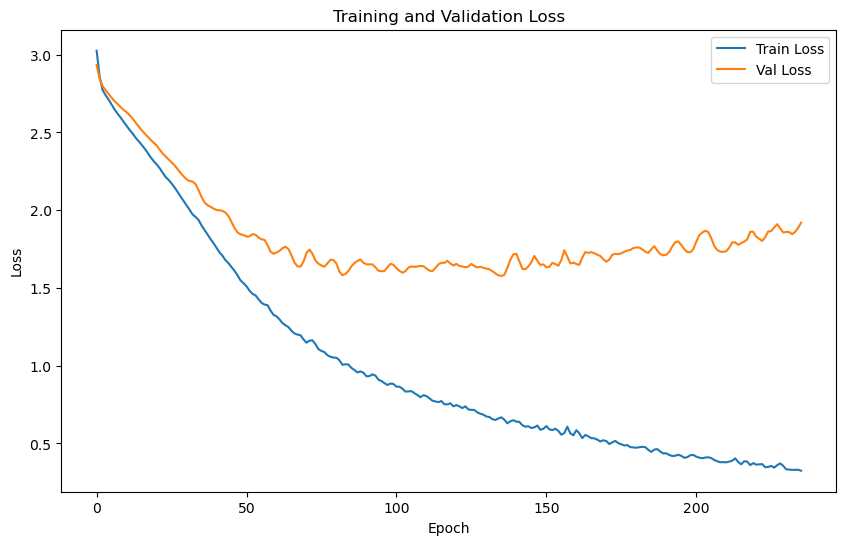

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.6294 | Test Accuracy: 41.14%


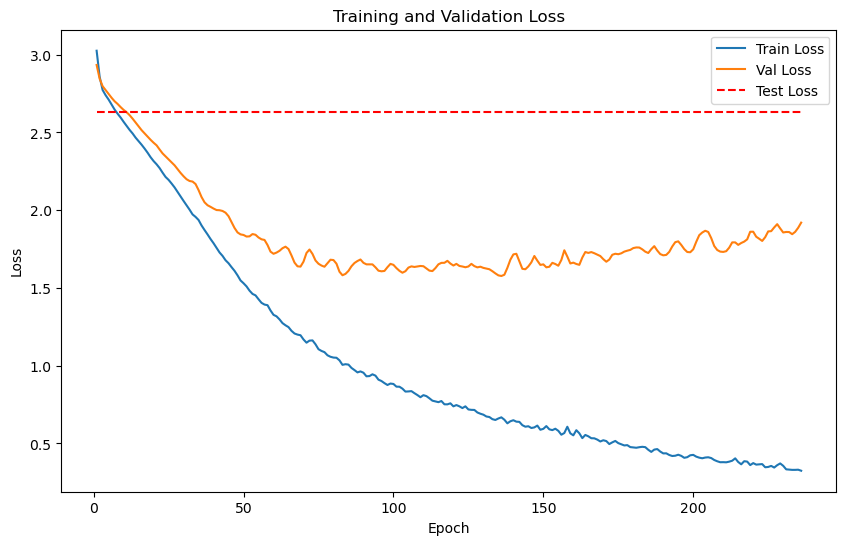

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10089, 64), 
Test labels shape: (10089,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.9661
Epoch [1/2000], Avg Train Loss: 8.9661
Epoch [1/2000], Avg Val Loss: 5.4704
Validation loss improved from inf to 5.4704. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.9199
Epoch [2/2000], Avg Train Loss: 8.9199
Epoch [2/2000], Avg Val Loss: 5.4182
Validation loss improved from 5.4704 to 5.4182. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.7892
Epoch [3/2000], Avg Train Loss: 8.7892
Epoch [3/2000], Avg Val Loss: 5.3668
Validation loss improved from 5.4182 to 5.3668. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.8199
Epoch [4/2000], Avg Train Loss: 8.8199
Epoch [4/2000], Avg Val Loss: 5.3164
Validation loss improved from 5.3668 to 5.3164. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.7546
Epoch [5/2000], Avg Train Loss: 8.7546
Epoch [5/2000], Avg Val Loss: 5.2670
Validation loss improved from 5.3164 to 5.2670. Saving mode

    Batch [1/1], Train Loss: 7.7861
Epoch [18/2000], Avg Train Loss: 7.7861
Epoch [18/2000], Avg Val Loss: 4.7106
Validation loss improved from 4.7484 to 4.7106. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 8.1524
Epoch [19/2000], Avg Train Loss: 8.1524
Epoch [19/2000], Avg Val Loss: 4.6735
Validation loss improved from 4.7106 to 4.6735. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 7.7827
Epoch [20/2000], Avg Train Loss: 7.7827
Epoch [20/2000], Avg Val Loss: 4.6374
Validation loss improved from 4.6735 to 4.6374. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 7.6110
Epoch [21/2000], Avg Train Loss: 7.6110
Epoch [21/2000], Avg Val Loss: 4.6020
Validation loss improved from 4.6374 to 4.6020. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 7.3603
Epoch [22/2000], Avg Train Loss: 7.3603
Epoch [22/2000], Avg Val Loss: 4.5678
Validation loss improved from 4.6020 to 4.

    Batch [1/1], Train Loss: 7.0526
Epoch [29/2000], Avg Train Loss: 7.0526
Epoch [29/2000], Avg Val Loss: 4.3506
Validation loss improved from 4.3792 to 4.3506. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 7.0332
Epoch [30/2000], Avg Train Loss: 7.0332
Epoch [30/2000], Avg Val Loss: 4.3229
Validation loss improved from 4.3506 to 4.3229. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 7.0502
Epoch [31/2000], Avg Train Loss: 7.0502
Epoch [31/2000], Avg Val Loss: 4.2962
Validation loss improved from 4.3229 to 4.2962. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 7.1540
Epoch [32/2000], Avg Train Loss: 7.1540
Epoch [32/2000], Avg Val Loss: 4.2704
Validation loss improved from 4.2962 to 4.2704. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.8199
Epoch [33/2000], Avg Train Loss: 6.8199
Epoch [33/2000], Avg Val Loss: 4.2452
Validation loss improved from 4.2704 to 4.

    Batch [1/1], Train Loss: 6.3776
Epoch [48/2000], Avg Train Loss: 6.3776
Epoch [48/2000], Avg Val Loss: 3.9465
Validation loss improved from 3.9624 to 3.9465. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 6.1057
Epoch [49/2000], Avg Train Loss: 6.1057
Epoch [49/2000], Avg Val Loss: 3.9310
Validation loss improved from 3.9465 to 3.9310. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 6.1982
Epoch [50/2000], Avg Train Loss: 6.1982
Epoch [50/2000], Avg Val Loss: 3.9161
Validation loss improved from 3.9310 to 3.9161. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.8737
Epoch [51/2000], Avg Train Loss: 5.8737
Epoch [51/2000], Avg Val Loss: 3.9016
Validation loss improved from 3.9161 to 3.9016. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 6.0695
Epoch [52/2000], Avg Train Loss: 6.0695
Epoch [52/2000], Avg Val Loss: 3.8876
Validation loss improved from 3.9016 to 3.

    Batch [1/1], Train Loss: 5.7336
Epoch [64/2000], Avg Train Loss: 5.7336
Epoch [64/2000], Avg Val Loss: 3.7556
Validation loss improved from 3.7644 to 3.7556. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 5.5473
Epoch [65/2000], Avg Train Loss: 5.5473
Epoch [65/2000], Avg Val Loss: 3.7471
Validation loss improved from 3.7556 to 3.7471. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 5.4493
Epoch [66/2000], Avg Train Loss: 5.4493
Epoch [66/2000], Avg Val Loss: 3.7388
Validation loss improved from 3.7471 to 3.7388. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 5.2870
Epoch [67/2000], Avg Train Loss: 5.2870
Epoch [67/2000], Avg Val Loss: 3.7310
Validation loss improved from 3.7388 to 3.7310. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 5.2835
Epoch [68/2000], Avg Train Loss: 5.2835
Epoch [68/2000], Avg Val Loss: 3.7234
Validation loss improved from 3.7310 to 3.

    Batch [1/1], Train Loss: 5.2350
Epoch [73/2000], Avg Train Loss: 5.2350
Epoch [73/2000], Avg Val Loss: 3.6899
Validation loss improved from 3.6961 to 3.6899. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.1753
Epoch [74/2000], Avg Train Loss: 5.1753
Epoch [74/2000], Avg Val Loss: 3.6840
Validation loss improved from 3.6899 to 3.6840. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 5.1508
Epoch [75/2000], Avg Train Loss: 5.1508
Epoch [75/2000], Avg Val Loss: 3.6783
Validation loss improved from 3.6840 to 3.6783. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 5.2747
Epoch [76/2000], Avg Train Loss: 5.2747
Epoch [76/2000], Avg Val Loss: 3.6729
Validation loss improved from 3.6783 to 3.6729. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 5.1442
Epoch [77/2000], Avg Train Loss: 5.1442
Epoch [77/2000], Avg Val Loss: 3.6676
Validation loss improved from 3.6729 to 3.

Epoch [96/2000], Avg Val Loss: 3.6005
Validation loss improved from 3.6028 to 3.6005. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.7179
Epoch [97/2000], Avg Train Loss: 4.7179
Epoch [97/2000], Avg Val Loss: 3.5982
Validation loss improved from 3.6005 to 3.5982. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 4.6416
Epoch [98/2000], Avg Train Loss: 4.6416
Epoch [98/2000], Avg Val Loss: 3.5959
Validation loss improved from 3.5982 to 3.5959. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 4.7235
Epoch [99/2000], Avg Train Loss: 4.7235
Epoch [99/2000], Avg Val Loss: 3.5938
Validation loss improved from 3.5959 to 3.5938. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 4.7228
Epoch [100/2000], Avg Train Loss: 4.7228
Epoch [100/2000], Avg Val Loss: 3.5917
Validation loss improved from 3.5938 to 3.5917. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/1], 

    Batch [1/1], Train Loss: 4.4454
Epoch [112/2000], Avg Train Loss: 4.4454
Epoch [112/2000], Avg Val Loss: 3.5730
Validation loss improved from 3.5742 to 3.5730. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 4.5337
Epoch [113/2000], Avg Train Loss: 4.5337
Epoch [113/2000], Avg Val Loss: 3.5718
Validation loss improved from 3.5730 to 3.5718. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 4.4588
Epoch [114/2000], Avg Train Loss: 4.4588
Epoch [114/2000], Avg Val Loss: 3.5706
Validation loss improved from 3.5718 to 3.5706. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 4.4026
Epoch [115/2000], Avg Train Loss: 4.4026
Epoch [115/2000], Avg Val Loss: 3.5695
Validation loss improved from 3.5706 to 3.5695. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 4.4579
Epoch [116/2000], Avg Train Loss: 4.4579
Epoch [116/2000], Avg Val Loss: 3.5684
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2253
Epoch [145/2000], Avg Train Loss: 4.2253
Epoch [145/2000], Avg Val Loss: 3.5463
Validation loss improved from 3.5469 to 3.5463. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 4.1798
Epoch [146/2000], Avg Train Loss: 4.1798
Epoch [146/2000], Avg Val Loss: 3.5458
Validation loss improved from 3.5463 to 3.5458. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 4.0739
Epoch [147/2000], Avg Train Loss: 4.0739
Epoch [147/2000], Avg Val Loss: 3.5453
Validation loss improved from 3.5458 to 3.5453. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 4.1856
Epoch [148/2000], Avg Train Loss: 4.1856
Epoch [148/2000], Avg Val Loss: 3.5448
Validation loss improved from 3.5453 to 3.5448. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 4.2840
Epoch [149/2000], Avg Train Loss: 4.2840
Epoch [149/2000], Avg Val Loss: 3.5443
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1423
Epoch [162/2000], Avg Train Loss: 4.1423
Epoch [162/2000], Avg Val Loss: 3.5377
Validation loss improved from 3.5382 to 3.5377. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 4.1527
Epoch [163/2000], Avg Train Loss: 4.1527
Epoch [163/2000], Avg Val Loss: 3.5373
Validation loss improved from 3.5377 to 3.5373. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 4.1004
Epoch [164/2000], Avg Train Loss: 4.1004
Epoch [164/2000], Avg Val Loss: 3.5368
Validation loss improved from 3.5373 to 3.5368. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 4.0288
Epoch [165/2000], Avg Train Loss: 4.0288
Epoch [165/2000], Avg Val Loss: 3.5364
Validation loss improved from 3.5368 to 3.5364. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 4.2475
Epoch [166/2000], Avg Train Loss: 4.2475
Epoch [166/2000], Avg Val Loss: 3.5359
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9802
Epoch [193/2000], Avg Train Loss: 3.9802
Epoch [193/2000], Avg Val Loss: 3.5205
Validation loss improved from 3.5211 to 3.5205. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 3.9532
Epoch [194/2000], Avg Train Loss: 3.9532
Epoch [194/2000], Avg Val Loss: 3.5199
Validation loss improved from 3.5205 to 3.5199. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 4.0036
Epoch [195/2000], Avg Train Loss: 4.0036
Epoch [195/2000], Avg Val Loss: 3.5192
Validation loss improved from 3.5199 to 3.5192. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 3.9086
Epoch [196/2000], Avg Train Loss: 3.9086
Epoch [196/2000], Avg Val Loss: 3.5186
Validation loss improved from 3.5192 to 3.5186. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 3.9272
Epoch [197/2000], Avg Train Loss: 3.9272
Epoch [197/2000], Avg Val Loss: 3.5179
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0033
Epoch [208/2000], Avg Train Loss: 4.0033
Epoch [208/2000], Avg Val Loss: 3.5110
Validation loss improved from 3.5117 to 3.5110. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 3.8724
Epoch [209/2000], Avg Train Loss: 3.8724
Epoch [209/2000], Avg Val Loss: 3.5104
Validation loss improved from 3.5110 to 3.5104. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 3.9218
Epoch [210/2000], Avg Train Loss: 3.9218
Epoch [210/2000], Avg Val Loss: 3.5097
Validation loss improved from 3.5104 to 3.5097. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 3.8228
Epoch [211/2000], Avg Train Loss: 3.8228
Epoch [211/2000], Avg Val Loss: 3.5090
Validation loss improved from 3.5097 to 3.5090. Saving model...

LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 3.9906
Epoch [212/2000], Avg Train Loss: 3.9906
Epoch [212/2000], Avg Val Loss: 3.5084
Validation loss improved fro

Epoch [236/2000], Avg Val Loss: 3.4910
Validation loss improved from 3.4918 to 3.4910. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 3.8931
Epoch [237/2000], Avg Train Loss: 3.8931
Epoch [237/2000], Avg Val Loss: 3.4903
Validation loss improved from 3.4910 to 3.4903. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 3.8723
Epoch [238/2000], Avg Train Loss: 3.8723
Epoch [238/2000], Avg Val Loss: 3.4895
Validation loss improved from 3.4903 to 3.4895. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 3.8058
Epoch [239/2000], Avg Train Loss: 3.8058
Epoch [239/2000], Avg Val Loss: 3.4888
Validation loss improved from 3.4895 to 3.4888. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 3.8420
Epoch [240/2000], Avg Train Loss: 3.8420
Epoch [240/2000], Avg Val Loss: 3.4881
Validation loss improved from 3.4888 to 3.4881. Saving model...

LOG: Epoch [241/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7493
Epoch [256/2000], Avg Train Loss: 3.7493
Epoch [256/2000], Avg Val Loss: 3.4764
Validation loss improved from 3.4771 to 3.4764. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 3.7760
Epoch [257/2000], Avg Train Loss: 3.7760
Epoch [257/2000], Avg Val Loss: 3.4756
Validation loss improved from 3.4764 to 3.4756. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 3.8244
Epoch [258/2000], Avg Train Loss: 3.8244
Epoch [258/2000], Avg Val Loss: 3.4749
Validation loss improved from 3.4756 to 3.4749. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 3.7761
Epoch [259/2000], Avg Train Loss: 3.7761
Epoch [259/2000], Avg Val Loss: 3.4742
Validation loss improved from 3.4749 to 3.4742. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 3.6877
Epoch [260/2000], Avg Train Loss: 3.6877
Epoch [260/2000], Avg Val Loss: 3.4735
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7770
Epoch [280/2000], Avg Train Loss: 3.7770
Epoch [280/2000], Avg Val Loss: 3.4590
Validation loss improved from 3.4598 to 3.4590. Saving model...

LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 3.7477
Epoch [281/2000], Avg Train Loss: 3.7477
Epoch [281/2000], Avg Val Loss: 3.4583
Validation loss improved from 3.4590 to 3.4583. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 3.8378
Epoch [282/2000], Avg Train Loss: 3.8378
Epoch [282/2000], Avg Val Loss: 3.4577
Validation loss improved from 3.4583 to 3.4577. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 3.6475
Epoch [283/2000], Avg Train Loss: 3.6475
Epoch [283/2000], Avg Val Loss: 3.4570
Validation loss improved from 3.4577 to 3.4570. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 3.7097
Epoch [284/2000], Avg Train Loss: 3.7097
Epoch [284/2000], Avg Val Loss: 3.4563
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7014
Epoch [302/2000], Avg Train Loss: 3.7014
Epoch [302/2000], Avg Val Loss: 3.4441
Validation loss improved from 3.4447 to 3.4441. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 3.7050
Epoch [303/2000], Avg Train Loss: 3.7050
Epoch [303/2000], Avg Val Loss: 3.4434
Validation loss improved from 3.4441 to 3.4434. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 3.6549
Epoch [304/2000], Avg Train Loss: 3.6549
Epoch [304/2000], Avg Val Loss: 3.4427
Validation loss improved from 3.4434 to 3.4427. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 3.7987
Epoch [305/2000], Avg Train Loss: 3.7987
Epoch [305/2000], Avg Val Loss: 3.4421
Validation loss improved from 3.4427 to 3.4421. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 3.6094
Epoch [306/2000], Avg Train Loss: 3.6094
Epoch [306/2000], Avg Val Loss: 3.4415
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6020
Epoch [324/2000], Avg Train Loss: 3.6020
Epoch [324/2000], Avg Val Loss: 3.4300
Validation loss improved from 3.4306 to 3.4300. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 3.6332
Epoch [325/2000], Avg Train Loss: 3.6332
Epoch [325/2000], Avg Val Loss: 3.4293
Validation loss improved from 3.4300 to 3.4293. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 3.6268
Epoch [326/2000], Avg Train Loss: 3.6268
Epoch [326/2000], Avg Val Loss: 3.4286
Validation loss improved from 3.4293 to 3.4286. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 3.6965
Epoch [327/2000], Avg Train Loss: 3.6965
Epoch [327/2000], Avg Val Loss: 3.4280
Validation loss improved from 3.4286 to 3.4280. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 3.7003
Epoch [328/2000], Avg Train Loss: 3.7003
Epoch [328/2000], Avg Val Loss: 3.4274
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5661
Epoch [352/2000], Avg Train Loss: 3.5661
Epoch [352/2000], Avg Val Loss: 3.4125
Validation loss improved from 3.4131 to 3.4125. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 3.5483
Epoch [353/2000], Avg Train Loss: 3.5483
Epoch [353/2000], Avg Val Loss: 3.4119
Validation loss improved from 3.4125 to 3.4119. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 3.6150
Epoch [354/2000], Avg Train Loss: 3.6150
Epoch [354/2000], Avg Val Loss: 3.4114
Validation loss improved from 3.4119 to 3.4114. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 3.5758
Epoch [355/2000], Avg Train Loss: 3.5758
Epoch [355/2000], Avg Val Loss: 3.4107
Validation loss improved from 3.4114 to 3.4107. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 3.6082
Epoch [356/2000], Avg Train Loss: 3.6082
Epoch [356/2000], Avg Val Loss: 3.4101
Validation loss improved fro

Epoch [369/2000], Avg Val Loss: 3.4025
Validation loss improved from 3.4031 to 3.4025. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 3.5932
Epoch [370/2000], Avg Train Loss: 3.5932
Epoch [370/2000], Avg Val Loss: 3.4020
Validation loss improved from 3.4025 to 3.4020. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 3.5377
Epoch [371/2000], Avg Train Loss: 3.5377
Epoch [371/2000], Avg Val Loss: 3.4014
Validation loss improved from 3.4020 to 3.4014. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 3.5894
Epoch [372/2000], Avg Train Loss: 3.5894
Epoch [372/2000], Avg Val Loss: 3.4007
Validation loss improved from 3.4014 to 3.4007. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 3.6127
Epoch [373/2000], Avg Train Loss: 3.6127
Epoch [373/2000], Avg Val Loss: 3.4001
Validation loss improved from 3.4007 to 3.4001. Saving model...

LOG: Epoch [374/2000] - Training
    Bat

Epoch [391/2000], Avg Val Loss: 3.3900
Validation loss improved from 3.3905 to 3.3900. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 3.5815
Epoch [392/2000], Avg Train Loss: 3.5815
Epoch [392/2000], Avg Val Loss: 3.3895
Validation loss improved from 3.3900 to 3.3895. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 3.5808
Epoch [393/2000], Avg Train Loss: 3.5808
Epoch [393/2000], Avg Val Loss: 3.3890
Validation loss improved from 3.3895 to 3.3890. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 3.5491
Epoch [394/2000], Avg Train Loss: 3.5491
Epoch [394/2000], Avg Val Loss: 3.3885
Validation loss improved from 3.3890 to 3.3885. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 3.5193
Epoch [395/2000], Avg Train Loss: 3.5193
Epoch [395/2000], Avg Val Loss: 3.3880
Validation loss improved from 3.3885 to 3.3880. Saving model...

LOG: Epoch [396/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5152
Epoch [414/2000], Avg Train Loss: 3.5152
Epoch [414/2000], Avg Val Loss: 3.3783
Validation loss improved from 3.3788 to 3.3783. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 3.5296
Epoch [415/2000], Avg Train Loss: 3.5296
Epoch [415/2000], Avg Val Loss: 3.3778
Validation loss improved from 3.3783 to 3.3778. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 3.5494
Epoch [416/2000], Avg Train Loss: 3.5494
Epoch [416/2000], Avg Val Loss: 3.3772
Validation loss improved from 3.3778 to 3.3772. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 3.4898
Epoch [417/2000], Avg Train Loss: 3.4898
Epoch [417/2000], Avg Val Loss: 3.3767
Validation loss improved from 3.3772 to 3.3767. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 3.5209
Epoch [418/2000], Avg Train Loss: 3.5209
Epoch [418/2000], Avg Val Loss: 3.3762
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4138
Epoch [437/2000], Avg Train Loss: 3.4138
Epoch [437/2000], Avg Val Loss: 3.3671
Validation loss improved from 3.3676 to 3.3671. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 3.4465
Epoch [438/2000], Avg Train Loss: 3.4465
Epoch [438/2000], Avg Val Loss: 3.3666
Validation loss improved from 3.3671 to 3.3666. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 3.5003
Epoch [439/2000], Avg Train Loss: 3.5003
Epoch [439/2000], Avg Val Loss: 3.3661
Validation loss improved from 3.3666 to 3.3661. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 3.4237
Epoch [440/2000], Avg Train Loss: 3.4237
Epoch [440/2000], Avg Val Loss: 3.3656
Validation loss improved from 3.3661 to 3.3656. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 3.5123
Epoch [441/2000], Avg Train Loss: 3.5123
Epoch [441/2000], Avg Val Loss: 3.3651
Validation loss improved fro

Epoch [459/2000], Avg Val Loss: 3.3558
Validation loss improved from 3.3562 to 3.3558. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 3.4240
Epoch [460/2000], Avg Train Loss: 3.4240
Epoch [460/2000], Avg Val Loss: 3.3553
Validation loss improved from 3.3558 to 3.3553. Saving model...

LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 3.4263
Epoch [461/2000], Avg Train Loss: 3.4263
Epoch [461/2000], Avg Val Loss: 3.3547
Validation loss improved from 3.3553 to 3.3547. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 3.4372
Epoch [462/2000], Avg Train Loss: 3.4372
Epoch [462/2000], Avg Val Loss: 3.3542
Validation loss improved from 3.3547 to 3.3542. Saving model...

LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 3.3844
Epoch [463/2000], Avg Train Loss: 3.3844
Epoch [463/2000], Avg Val Loss: 3.3537
Validation loss improved from 3.3542 to 3.3537. Saving model...

LOG: Epoch [464/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.3770
Epoch [481/2000], Avg Train Loss: 3.3770
Epoch [481/2000], Avg Val Loss: 3.3446
Validation loss improved from 3.3451 to 3.3446. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 3.2868
Epoch [482/2000], Avg Train Loss: 3.2868
Epoch [482/2000], Avg Val Loss: 3.3441
Validation loss improved from 3.3446 to 3.3441. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 3.3544
Epoch [483/2000], Avg Train Loss: 3.3544
Epoch [483/2000], Avg Val Loss: 3.3436
Validation loss improved from 3.3441 to 3.3436. Saving model...

LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 3.4626
Epoch [484/2000], Avg Train Loss: 3.4626
Epoch [484/2000], Avg Val Loss: 3.3432
Validation loss improved from 3.3436 to 3.3432. Saving model...

LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 3.4691
Epoch [485/2000], Avg Train Loss: 3.4691
Epoch [485/2000], Avg Val Loss: 3.3427
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4004
Epoch [503/2000], Avg Train Loss: 3.4004
Epoch [503/2000], Avg Val Loss: 3.3354
Validation loss improved from 3.3358 to 3.3354. Saving model...

LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 3.3399
Epoch [504/2000], Avg Train Loss: 3.3399
Epoch [504/2000], Avg Val Loss: 3.3349
Validation loss improved from 3.3354 to 3.3349. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 3.3650
Epoch [505/2000], Avg Train Loss: 3.3650
Epoch [505/2000], Avg Val Loss: 3.3345
Validation loss improved from 3.3349 to 3.3345. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 3.3892
Epoch [506/2000], Avg Train Loss: 3.3892
Epoch [506/2000], Avg Val Loss: 3.3342
Validation loss improved from 3.3345 to 3.3342. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 3.4038
Epoch [507/2000], Avg Train Loss: 3.4038
Epoch [507/2000], Avg Val Loss: 3.3338
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4510
Epoch [525/2000], Avg Train Loss: 3.4510
Epoch [525/2000], Avg Val Loss: 3.3268
Validation loss improved from 3.3273 to 3.3268. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 3.3726
Epoch [526/2000], Avg Train Loss: 3.3726
Epoch [526/2000], Avg Val Loss: 3.3265
Validation loss improved from 3.3268 to 3.3265. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 3.3636
Epoch [527/2000], Avg Train Loss: 3.3636
Epoch [527/2000], Avg Val Loss: 3.3261
Validation loss improved from 3.3265 to 3.3261. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 3.3224
Epoch [528/2000], Avg Train Loss: 3.3224
Epoch [528/2000], Avg Val Loss: 3.3257
Validation loss improved from 3.3261 to 3.3257. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 3.3590
Epoch [529/2000], Avg Train Loss: 3.3590
Epoch [529/2000], Avg Val Loss: 3.3254
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3620
Epoch [549/2000], Avg Train Loss: 3.3620
Epoch [549/2000], Avg Val Loss: 3.3183
Validation loss improved from 3.3185 to 3.3183. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 3.3005
Epoch [550/2000], Avg Train Loss: 3.3005
Epoch [550/2000], Avg Val Loss: 3.3180
Validation loss improved from 3.3183 to 3.3180. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 3.3523
Epoch [551/2000], Avg Train Loss: 3.3523
Epoch [551/2000], Avg Val Loss: 3.3178
Validation loss improved from 3.3180 to 3.3178. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 3.3133
Epoch [552/2000], Avg Train Loss: 3.3133
Epoch [552/2000], Avg Val Loss: 3.3175
Validation loss improved from 3.3178 to 3.3175. Saving model...

LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 3.3740
Epoch [553/2000], Avg Train Loss: 3.3740
Epoch [553/2000], Avg Val Loss: 3.3172
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2443
Epoch [578/2000], Avg Train Loss: 3.2443
Epoch [578/2000], Avg Val Loss: 3.3104
Validation loss improved from 3.3106 to 3.3104. Saving model...

LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 3.2731
Epoch [579/2000], Avg Train Loss: 3.2731
Epoch [579/2000], Avg Val Loss: 3.3101
Validation loss improved from 3.3104 to 3.3101. Saving model...

LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 3.2178
Epoch [580/2000], Avg Train Loss: 3.2178
Epoch [580/2000], Avg Val Loss: 3.3098
Validation loss improved from 3.3101 to 3.3098. Saving model...

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 3.2311
Epoch [581/2000], Avg Train Loss: 3.2311
Epoch [581/2000], Avg Val Loss: 3.3095
Validation loss improved from 3.3098 to 3.3095. Saving model...

LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 3.3177
Epoch [582/2000], Avg Train Loss: 3.3177
Epoch [582/2000], Avg Val Loss: 3.3092
Validation loss improved fro

Epoch [596/2000], Avg Val Loss: 3.3048
Validation loss improved from 3.3051 to 3.3048. Saving model...

LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 3.3043
Epoch [597/2000], Avg Train Loss: 3.3043
Epoch [597/2000], Avg Val Loss: 3.3046
Validation loss improved from 3.3048 to 3.3046. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 3.3280
Epoch [598/2000], Avg Train Loss: 3.3280
Epoch [598/2000], Avg Val Loss: 3.3043
Validation loss improved from 3.3046 to 3.3043. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 3.3381
Epoch [599/2000], Avg Train Loss: 3.3381
Epoch [599/2000], Avg Val Loss: 3.3041
Validation loss improved from 3.3043 to 3.3041. Saving model...

LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 3.3148
Epoch [600/2000], Avg Train Loss: 3.3148
Epoch [600/2000], Avg Val Loss: 3.3038
Validation loss improved from 3.3041 to 3.3038. Saving model...

LOG: Epoch [601/2000] - Training
    Bat

Epoch [620/2000], Avg Val Loss: 3.2993
Validation loss improved from 3.2996 to 3.2993. Saving model...

LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 3.3086
Epoch [621/2000], Avg Train Loss: 3.3086
Epoch [621/2000], Avg Val Loss: 3.2990
Validation loss improved from 3.2993 to 3.2990. Saving model...

LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 3.2478
Epoch [622/2000], Avg Train Loss: 3.2478
Epoch [622/2000], Avg Val Loss: 3.2987
Validation loss improved from 3.2990 to 3.2987. Saving model...

LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 3.2555
Epoch [623/2000], Avg Train Loss: 3.2555
Epoch [623/2000], Avg Val Loss: 3.2983
Validation loss improved from 3.2987 to 3.2983. Saving model...

LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 3.2582
Epoch [624/2000], Avg Train Loss: 3.2582
Epoch [624/2000], Avg Val Loss: 3.2980
Validation loss improved from 3.2983 to 3.2980. Saving model...

LOG: Epoch [625/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.2217
Epoch [634/2000], Avg Train Loss: 3.2217
Epoch [634/2000], Avg Val Loss: 3.2960
Validation loss improved from 3.2962 to 3.2960. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 3.2725
Epoch [635/2000], Avg Train Loss: 3.2725
Epoch [635/2000], Avg Val Loss: 3.2958
Validation loss improved from 3.2960 to 3.2958. Saving model...

LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 3.2664
Epoch [636/2000], Avg Train Loss: 3.2664
Epoch [636/2000], Avg Val Loss: 3.2956
Validation loss improved from 3.2958 to 3.2956. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 3.1970
Epoch [637/2000], Avg Train Loss: 3.1970
Epoch [637/2000], Avg Val Loss: 3.2953
Validation loss improved from 3.2956 to 3.2953. Saving model...

LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 3.2644
Epoch [638/2000], Avg Train Loss: 3.2644
Epoch [638/2000], Avg Val Loss: 3.2950
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1446
Epoch [661/2000], Avg Train Loss: 3.1446
Epoch [661/2000], Avg Val Loss: 3.2907
Validation loss improved from 3.2908 to 3.2907. Saving model...

LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 3.3253
Epoch [662/2000], Avg Train Loss: 3.3253
Epoch [662/2000], Avg Val Loss: 3.2906
Validation loss improved from 3.2907 to 3.2906. Saving model...

LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 3.1962
Epoch [663/2000], Avg Train Loss: 3.1962
Epoch [663/2000], Avg Val Loss: 3.2904
Validation loss improved from 3.2906 to 3.2904. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 3.2394
Epoch [664/2000], Avg Train Loss: 3.2394
Epoch [664/2000], Avg Val Loss: 3.2902
Validation loss improved from 3.2904 to 3.2902. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 3.2079
Epoch [665/2000], Avg Train Loss: 3.2079
Epoch [665/2000], Avg Val Loss: 3.2900
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2126
Epoch [680/2000], Avg Train Loss: 3.2126
Epoch [680/2000], Avg Val Loss: 3.2865
Validation loss improved from 3.2867 to 3.2865. Saving model...

LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 3.2011
Epoch [681/2000], Avg Train Loss: 3.2011
Epoch [681/2000], Avg Val Loss: 3.2863
Validation loss improved from 3.2865 to 3.2863. Saving model...

LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 3.2274
Epoch [682/2000], Avg Train Loss: 3.2274
Epoch [682/2000], Avg Val Loss: 3.2861
Validation loss improved from 3.2863 to 3.2861. Saving model...

LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 3.2576
Epoch [683/2000], Avg Train Loss: 3.2576
Epoch [683/2000], Avg Val Loss: 3.2858
Validation loss improved from 3.2861 to 3.2858. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 3.1883
Epoch [684/2000], Avg Train Loss: 3.1883
Epoch [684/2000], Avg Val Loss: 3.2856
Validation loss improved fro

Epoch [707/2000], Avg Val Loss: 3.2834
Validation loss improved from 3.2834 to 3.2834. Saving model...

LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 3.1577
Epoch [708/2000], Avg Train Loss: 3.1577
Epoch [708/2000], Avg Val Loss: 3.2832
Validation loss improved from 3.2834 to 3.2832. Saving model...

LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 3.1975
Epoch [709/2000], Avg Train Loss: 3.1975
Epoch [709/2000], Avg Val Loss: 3.2832
Validation loss improved from 3.2832 to 3.2832. Saving model...

LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 3.1743
Epoch [710/2000], Avg Train Loss: 3.1743
Epoch [710/2000], Avg Val Loss: 3.2831
Validation loss improved from 3.2832 to 3.2831. Saving model...

LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 3.1515
Epoch [711/2000], Avg Train Loss: 3.1515
Epoch [711/2000], Avg Val Loss: 3.2831
Validation loss improved from 3.2831 to 3.2831. Saving model...

LOG: Epoch [712/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.1692
Epoch [727/2000], Avg Train Loss: 3.1692
Epoch [727/2000], Avg Val Loss: 3.2797
Validation loss improved from 3.2799 to 3.2797. Saving model...

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 3.2144
Epoch [728/2000], Avg Train Loss: 3.2144
Epoch [728/2000], Avg Val Loss: 3.2794
Validation loss improved from 3.2797 to 3.2794. Saving model...

LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 3.1264
Epoch [729/2000], Avg Train Loss: 3.1264
Epoch [729/2000], Avg Val Loss: 3.2791
Validation loss improved from 3.2794 to 3.2791. Saving model...

LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 3.1678
Epoch [730/2000], Avg Train Loss: 3.1678
Epoch [730/2000], Avg Val Loss: 3.2789
Validation loss improved from 3.2791 to 3.2789. Saving model...

LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 3.1407
Epoch [731/2000], Avg Train Loss: 3.1407
Epoch [731/2000], Avg Val Loss: 3.2786
Validation loss improved fro

Epoch [751/2000], Avg Val Loss: 3.2740
Validation loss improved from 3.2742 to 3.2740. Saving model...

LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 3.1975
Epoch [752/2000], Avg Train Loss: 3.1975
Epoch [752/2000], Avg Val Loss: 3.2738
Validation loss improved from 3.2740 to 3.2738. Saving model...

LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 3.1551
Epoch [753/2000], Avg Train Loss: 3.1551
Epoch [753/2000], Avg Val Loss: 3.2737
Validation loss improved from 3.2738 to 3.2737. Saving model...

LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 3.1228
Epoch [754/2000], Avg Train Loss: 3.1228
Epoch [754/2000], Avg Val Loss: 3.2736
Validation loss improved from 3.2737 to 3.2736. Saving model...

LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 3.1016
Epoch [755/2000], Avg Train Loss: 3.1016
Epoch [755/2000], Avg Val Loss: 3.2735
Validation loss improved from 3.2736 to 3.2735. Saving model...

LOG: Epoch [756/2000] - Training
    Bat

Epoch [769/2000], Avg Val Loss: 3.2737
Validation loss did not improve. Patience: 11/100

LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 3.0832
Epoch [770/2000], Avg Train Loss: 3.0832
Epoch [770/2000], Avg Val Loss: 3.2737
Validation loss did not improve. Patience: 12/100

LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 3.1296
Epoch [771/2000], Avg Train Loss: 3.1296
Epoch [771/2000], Avg Val Loss: 3.2736
Validation loss did not improve. Patience: 13/100

LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 3.1263
Epoch [772/2000], Avg Train Loss: 3.1263
Epoch [772/2000], Avg Val Loss: 3.2735
Validation loss did not improve. Patience: 14/100

LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 3.1213
Epoch [773/2000], Avg Train Loss: 3.1213
Epoch [773/2000], Avg Val Loss: 3.2734
Validation loss improved from 3.2735 to 3.2734. Saving model...

LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 3.1070
Epoch [774/2000], Avg Train

    Batch [1/1], Train Loss: 3.1384
Epoch [794/2000], Avg Train Loss: 3.1384
Epoch [794/2000], Avg Val Loss: 3.2726
Validation loss did not improve. Patience: 8/100

LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 3.1021
Epoch [795/2000], Avg Train Loss: 3.1021
Epoch [795/2000], Avg Val Loss: 3.2727
Validation loss did not improve. Patience: 9/100

LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 3.1490
Epoch [796/2000], Avg Train Loss: 3.1490
Epoch [796/2000], Avg Val Loss: 3.2727
Validation loss did not improve. Patience: 10/100

LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 3.0138
Epoch [797/2000], Avg Train Loss: 3.0138
Epoch [797/2000], Avg Val Loss: 3.2727
Validation loss did not improve. Patience: 11/100

LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 3.1024
Epoch [798/2000], Avg Train Loss: 3.1024
Epoch [798/2000], Avg Val Loss: 3.2728
Validation loss did not improve. Patience: 12/100

LOG: Epoch [799/2000] - Training
  

    Batch [1/1], Train Loss: 3.1130
Epoch [811/2000], Avg Train Loss: 3.1130
Epoch [811/2000], Avg Val Loss: 3.2723
Validation loss did not improve. Patience: 25/100

LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 3.0308
Epoch [812/2000], Avg Train Loss: 3.0308
Epoch [812/2000], Avg Val Loss: 3.2723
Validation loss improved from 3.2723 to 3.2723. Saving model...

LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 3.0909
Epoch [813/2000], Avg Train Loss: 3.0909
Epoch [813/2000], Avg Val Loss: 3.2722
Validation loss improved from 3.2723 to 3.2722. Saving model...

LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 3.1246
Epoch [814/2000], Avg Train Loss: 3.1246
Epoch [814/2000], Avg Val Loss: 3.2722
Validation loss improved from 3.2722 to 3.2722. Saving model...

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 3.0744
Epoch [815/2000], Avg Train Loss: 3.0744
Epoch [815/2000], Avg Val Loss: 3.2722
Validation loss did not improve. Patience:

    Batch [1/1], Train Loss: 3.0685
Epoch [836/2000], Avg Train Loss: 3.0685
Epoch [836/2000], Avg Val Loss: 3.2723
Validation loss did not improve. Patience: 22/100

LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 3.0643
Epoch [837/2000], Avg Train Loss: 3.0643
Epoch [837/2000], Avg Val Loss: 3.2723
Validation loss did not improve. Patience: 23/100

LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 3.0330
Epoch [838/2000], Avg Train Loss: 3.0330
Epoch [838/2000], Avg Val Loss: 3.2722
Validation loss improved from 3.2722 to 3.2722. Saving model...

LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 3.1106
Epoch [839/2000], Avg Train Loss: 3.1106
Epoch [839/2000], Avg Val Loss: 3.2721
Validation loss improved from 3.2722 to 3.2721. Saving model...

LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 3.0435
Epoch [840/2000], Avg Train Loss: 3.0435
Epoch [840/2000], Avg Val Loss: 3.2720
Validation loss improved from 3.2721 to 3.2720. Saving m

Epoch [853/2000], Avg Val Loss: 3.2694
Validation loss improved from 3.2697 to 3.2694. Saving model...

LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 3.0291
Epoch [854/2000], Avg Train Loss: 3.0291
Epoch [854/2000], Avg Val Loss: 3.2693
Validation loss improved from 3.2694 to 3.2693. Saving model...

LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 3.0717
Epoch [855/2000], Avg Train Loss: 3.0717
Epoch [855/2000], Avg Val Loss: 3.2691
Validation loss improved from 3.2693 to 3.2691. Saving model...

LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 3.1084
Epoch [856/2000], Avg Train Loss: 3.1084
Epoch [856/2000], Avg Val Loss: 3.2691
Validation loss improved from 3.2691 to 3.2691. Saving model...

LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 3.0078
Epoch [857/2000], Avg Train Loss: 3.0078
Epoch [857/2000], Avg Val Loss: 3.2689
Validation loss improved from 3.2691 to 3.2689. Saving model...

LOG: Epoch [858/2000] - Training
    Bat

Epoch [881/2000], Avg Val Loss: 3.2687
Validation loss did not improve. Patience: 18/100

LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 3.0802
Epoch [882/2000], Avg Train Loss: 3.0802
Epoch [882/2000], Avg Val Loss: 3.2687
Validation loss did not improve. Patience: 19/100

LOG: Epoch [883/2000] - Training
    Batch [1/1], Train Loss: 2.9876
Epoch [883/2000], Avg Train Loss: 2.9876
Epoch [883/2000], Avg Val Loss: 3.2688
Validation loss did not improve. Patience: 20/100

LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 3.0209
Epoch [884/2000], Avg Train Loss: 3.0209
Epoch [884/2000], Avg Val Loss: 3.2689
Validation loss did not improve. Patience: 21/100

LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 3.0257
Epoch [885/2000], Avg Train Loss: 3.0257
Epoch [885/2000], Avg Val Loss: 3.2690
Validation loss did not improve. Patience: 22/100

LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 3.0317
Epoch [886/2000], Avg Train Loss: 3.0317


    Batch [1/1], Train Loss: 3.0715
Epoch [896/2000], Avg Train Loss: 3.0715
Epoch [896/2000], Avg Val Loss: 3.2685
Validation loss did not improve. Patience: 33/100

LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 3.0304
Epoch [897/2000], Avg Train Loss: 3.0304
Epoch [897/2000], Avg Val Loss: 3.2685
Validation loss did not improve. Patience: 34/100

LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 3.0204
Epoch [898/2000], Avg Train Loss: 3.0204
Epoch [898/2000], Avg Val Loss: 3.2684
Validation loss did not improve. Patience: 35/100

LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 2.9844
Epoch [899/2000], Avg Train Loss: 2.9844
Epoch [899/2000], Avg Val Loss: 3.2684
Validation loss did not improve. Patience: 36/100

LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 3.0510
Epoch [900/2000], Avg Train Loss: 3.0510
Epoch [900/2000], Avg Val Loss: 3.2683
Validation loss did not improve. Patience: 37/100

LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 3.0172
Epoch [928/2000], Avg Train Loss: 3.0172
Epoch [928/2000], Avg Val Loss: 3.2689
Validation loss did not improve. Patience: 22/100

LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 3.0156
Epoch [929/2000], Avg Train Loss: 3.0156
Epoch [929/2000], Avg Val Loss: 3.2686
Validation loss did not improve. Patience: 23/100

LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 2.9796
Epoch [930/2000], Avg Train Loss: 2.9796
Epoch [930/2000], Avg Val Loss: 3.2684
Validation loss did not improve. Patience: 24/100

LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 2.9919
Epoch [931/2000], Avg Train Loss: 2.9919
Epoch [931/2000], Avg Val Loss: 3.2682
Validation loss did not improve. Patience: 25/100

LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 3.0271
Epoch [932/2000], Avg Train Loss: 3.0271
Epoch [932/2000], Avg Val Loss: 3.2681
Validation loss did not improve. Patience: 26/100

LOG: Epoch [933/2000] - Training


Epoch [940/2000], Avg Val Loss: 3.2672
Validation loss improved from 3.2673 to 3.2672. Saving model...

LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 3.0000
Epoch [941/2000], Avg Train Loss: 3.0000
Epoch [941/2000], Avg Val Loss: 3.2671
Validation loss improved from 3.2672 to 3.2671. Saving model...

LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 3.0059
Epoch [942/2000], Avg Train Loss: 3.0059
Epoch [942/2000], Avg Val Loss: 3.2668
Validation loss improved from 3.2671 to 3.2668. Saving model...

LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 3.0640
Epoch [943/2000], Avg Train Loss: 3.0640
Epoch [943/2000], Avg Val Loss: 3.2666
Validation loss improved from 3.2668 to 3.2666. Saving model...

LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 3.0165
Epoch [944/2000], Avg Train Loss: 3.0165
Epoch [944/2000], Avg Val Loss: 3.2664
Validation loss improved from 3.2666 to 3.2664. Saving model...

LOG: Epoch [945/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.9579
Epoch [974/2000], Avg Train Loss: 2.9579
Epoch [974/2000], Avg Val Loss: 3.2662
Validation loss did not improve. Patience: 6/100

LOG: Epoch [975/2000] - Training
    Batch [1/1], Train Loss: 2.9664
Epoch [975/2000], Avg Train Loss: 2.9664
Epoch [975/2000], Avg Val Loss: 3.2663
Validation loss did not improve. Patience: 7/100

LOG: Epoch [976/2000] - Training
    Batch [1/1], Train Loss: 2.9843
Epoch [976/2000], Avg Train Loss: 2.9843
Epoch [976/2000], Avg Val Loss: 3.2664
Validation loss did not improve. Patience: 8/100

LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 3.0051
Epoch [977/2000], Avg Train Loss: 3.0051
Epoch [977/2000], Avg Val Loss: 3.2664
Validation loss did not improve. Patience: 9/100

LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 2.9760
Epoch [978/2000], Avg Train Loss: 2.9760
Epoch [978/2000], Avg Val Loss: 3.2664
Validation loss did not improve. Patience: 10/100

LOG: Epoch [979/2000] - Training
    

    Batch [1/1], Train Loss: 2.9290
Epoch [987/2000], Avg Train Loss: 2.9290
Epoch [987/2000], Avg Val Loss: 3.2673
Validation loss did not improve. Patience: 19/100

LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 3.0022
Epoch [988/2000], Avg Train Loss: 3.0022
Epoch [988/2000], Avg Val Loss: 3.2674
Validation loss did not improve. Patience: 20/100

LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 2.9654
Epoch [989/2000], Avg Train Loss: 2.9654
Epoch [989/2000], Avg Val Loss: 3.2674
Validation loss did not improve. Patience: 21/100

LOG: Epoch [990/2000] - Training
    Batch [1/1], Train Loss: 2.9615
Epoch [990/2000], Avg Train Loss: 2.9615
Epoch [990/2000], Avg Val Loss: 3.2674
Validation loss did not improve. Patience: 22/100

LOG: Epoch [991/2000] - Training
    Batch [1/1], Train Loss: 2.8995
Epoch [991/2000], Avg Train Loss: 2.8995
Epoch [991/2000], Avg Val Loss: 3.2675
Validation loss did not improve. Patience: 23/100

LOG: Epoch [992/2000] - Training


    Batch [1/1], Train Loss: 2.9624
Epoch [1020/2000], Avg Train Loss: 2.9624
Epoch [1020/2000], Avg Val Loss: 3.2695
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1021/2000] - Training
    Batch [1/1], Train Loss: 2.9556
Epoch [1021/2000], Avg Train Loss: 2.9556
Epoch [1021/2000], Avg Val Loss: 3.2696
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1022/2000] - Training
    Batch [1/1], Train Loss: 2.9582
Epoch [1022/2000], Avg Train Loss: 2.9582
Epoch [1022/2000], Avg Val Loss: 3.2697
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1023/2000] - Training
    Batch [1/1], Train Loss: 3.0040
Epoch [1023/2000], Avg Train Loss: 3.0040
Epoch [1023/2000], Avg Val Loss: 3.2698
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1024/2000] - Training
    Batch [1/1], Train Loss: 2.9996
Epoch [1024/2000], Avg Train Loss: 2.9996
Epoch [1024/2000], Avg Val Loss: 3.2699
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1025/20

Epoch [1033/2000], Avg Val Loss: 3.2718
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 2.9284
Epoch [1034/2000], Avg Train Loss: 2.9284
Epoch [1034/2000], Avg Val Loss: 3.2718
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1035/2000] - Training
    Batch [1/1], Train Loss: 2.9335
Epoch [1035/2000], Avg Train Loss: 2.9335
Epoch [1035/2000], Avg Val Loss: 3.2720
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1036/2000] - Training
    Batch [1/1], Train Loss: 3.0004
Epoch [1036/2000], Avg Train Loss: 3.0004
Epoch [1036/2000], Avg Val Loss: 3.2721
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1037/2000] - Training
    Batch [1/1], Train Loss: 2.8892
Epoch [1037/2000], Avg Train Loss: 2.8892
Epoch [1037/2000], Avg Val Loss: 3.2720
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1038/2000] - Training
    Batch [1/1], Train Loss: 2.9352
Epoch [1038/2000], Avg Trai

Epoch [1065/2000], Avg Val Loss: 3.2755
Validation loss did not improve. Patience: 97/100

LOG: Epoch [1066/2000] - Training
    Batch [1/1], Train Loss: 2.9433
Epoch [1066/2000], Avg Train Loss: 2.9433
Epoch [1066/2000], Avg Val Loss: 3.2756
Validation loss did not improve. Patience: 98/100

LOG: Epoch [1067/2000] - Training
    Batch [1/1], Train Loss: 2.8990
Epoch [1067/2000], Avg Train Loss: 2.8990
Epoch [1067/2000], Avg Val Loss: 3.2756
Validation loss did not improve. Patience: 99/100

LOG: Epoch [1068/2000] - Training
    Batch [1/1], Train Loss: 2.8912
Epoch [1068/2000], Avg Train Loss: 2.8912
Epoch [1068/2000], Avg Val Loss: 3.2757
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 1068. No improvement for 100 epochs.


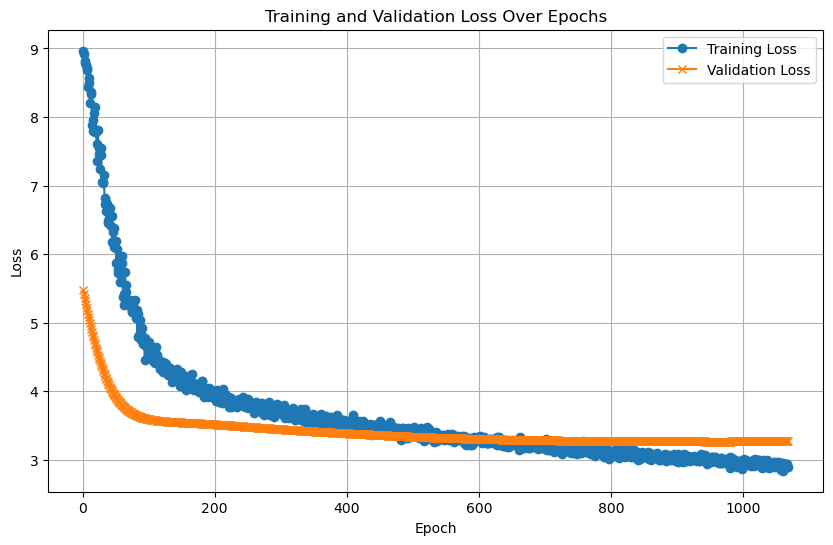

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/40], Loss: 5.0559
Test Batch [20/40], Loss: 5.0368
Test Batch [30/40], Loss: 4.5813
Test Batch [40/40], Loss: 4.5895

Test Loss: 4.9246


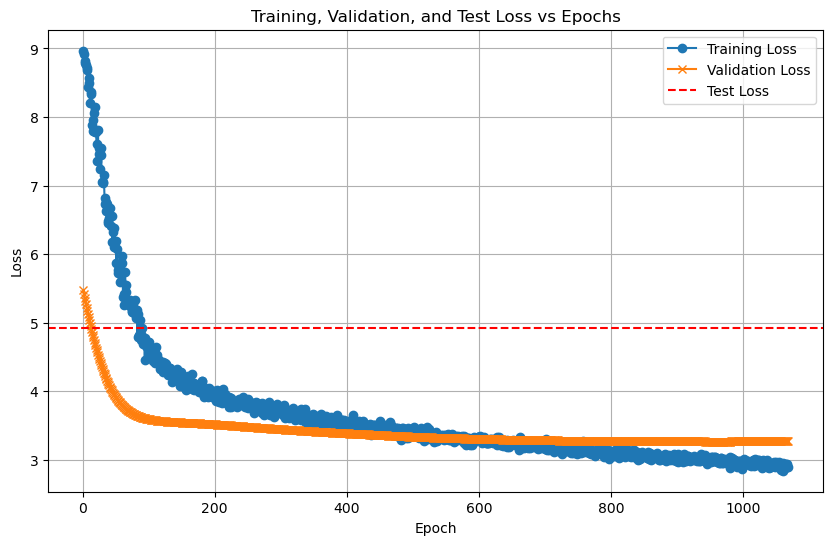

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/40 for test dataset.


  Processed batch 20/40 for test dataset.
  Processed batch 30/40 for test dataset.
  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 60.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.60      0.60      0.60         5
           2       0.00      0.00      0.00         5
           3       0.80      0.80      0.80         5
           4       0.80      0.80      0.80         5
           5       0.80      0.80      0.80         5
           6       0.62      1.00      0.77         5
           7       0.43      0.60      0.50         5
           8       1.00      1.00      1.00         5
           9       0.50      0.40      0.44         5
          10       0.50      0.20      0.29         5
          11       0.38      0.60      0.46         5
          12       0.50      1.00      0.67         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8115  |  Val Loss: 2.7908
Validation loss improved from inf to 2.7908.
[Epoch 2/1000] Train Loss: 2.7966  |  Val Loss: 2.7784
Validation loss improved from 2.7908 to 2.7784.
[Epoch 3/1000] Train Loss: 2.7824  |  Val Loss: 2.7674
Validation loss improved from 2.7784 to 2.7674.
[Epoch 4/1000] Train Loss: 2.7695  |  Val Loss: 2.7573
Validation loss improved from 2.7674 to 2.7573.
[Epoch 5/1000] Train Loss: 2.7571  |  Val Loss: 2.7479
Validation loss improved from 2.7573 to 2.7479.
[Epoch 6/1000] Train Loss: 2.7474  |  Val Loss: 2.7388
Validation loss improved from 2.7479 to 2.7388.
[Epoch 7/1000] Train Loss: 2.7388  |  Val Loss: 2.7303
Validation loss improved from 2.7388 to 2.7303.
[Epoch 8/1000] Train Loss: 2.7303  |  Val Loss: 2.7224
Validation loss improved from 2.7303 to 2.7224.
[Epoch 9/1000] Train Loss: 2.7219  |  Val Loss: 2.7151
Validation loss improved from 2.7224 to 2.7151.
[Epoch 10/1000] Train Loss: 2.7141  |  Val Loss: 2.7079
Validation loss impr

[Epoch 18/1000] Train Loss: 2.6561  |  Val Loss: 2.6518
Validation loss improved from 2.6583 to 2.6518.
[Epoch 19/1000] Train Loss: 2.6493  |  Val Loss: 2.6453
Validation loss improved from 2.6518 to 2.6453.
[Epoch 20/1000] Train Loss: 2.6424  |  Val Loss: 2.6393
Validation loss improved from 2.6453 to 2.6393.
[Epoch 21/1000] Train Loss: 2.6354  |  Val Loss: 2.6333
Validation loss improved from 2.6393 to 2.6333.
[Epoch 22/1000] Train Loss: 2.6286  |  Val Loss: 2.6273
Validation loss improved from 2.6333 to 2.6273.
[Epoch 23/1000] Train Loss: 2.6217  |  Val Loss: 2.6213
Validation loss improved from 2.6273 to 2.6213.
[Epoch 24/1000] Train Loss: 2.6147  |  Val Loss: 2.6153
Validation loss improved from 2.6213 to 2.6153.
[Epoch 25/1000] Train Loss: 2.6074  |  Val Loss: 2.6092
Validation loss improved from 2.6153 to 2.6092.
[Epoch 26/1000] Train Loss: 2.6005  |  Val Loss: 2.6028
Validation loss improved from 2.6092 to 2.6028.
[Epoch 27/1000] Train Loss: 2.5929  |  Val Loss: 2.5964
Validati

[Epoch 36/1000] Train Loss: 2.5262  |  Val Loss: 2.5392
Validation loss improved from 2.5452 to 2.5392.
[Epoch 37/1000] Train Loss: 2.5189  |  Val Loss: 2.5331
Validation loss improved from 2.5392 to 2.5331.
[Epoch 38/1000] Train Loss: 2.5116  |  Val Loss: 2.5271
Validation loss improved from 2.5331 to 2.5271.
[Epoch 39/1000] Train Loss: 2.5041  |  Val Loss: 2.5212
Validation loss improved from 2.5271 to 2.5212.
[Epoch 40/1000] Train Loss: 2.4965  |  Val Loss: 2.5153
Validation loss improved from 2.5212 to 2.5153.
[Epoch 41/1000] Train Loss: 2.4892  |  Val Loss: 2.5094
Validation loss improved from 2.5153 to 2.5094.
[Epoch 42/1000] Train Loss: 2.4816  |  Val Loss: 2.5035
Validation loss improved from 2.5094 to 2.5035.
[Epoch 43/1000] Train Loss: 2.4738  |  Val Loss: 2.4973
Validation loss improved from 2.5035 to 2.4973.
[Epoch 44/1000] Train Loss: 2.4667  |  Val Loss: 2.4910
Validation loss improved from 2.4973 to 2.4910.
[Epoch 45/1000] Train Loss: 2.4584  |  Val Loss: 2.4848
Validati

[Epoch 61/1000] Train Loss: 2.3369  |  Val Loss: 2.3938
Validation loss improved from 2.3986 to 2.3938.
[Epoch 62/1000] Train Loss: 2.3299  |  Val Loss: 2.3890
Validation loss improved from 2.3938 to 2.3890.
[Epoch 63/1000] Train Loss: 2.3225  |  Val Loss: 2.3842
Validation loss improved from 2.3890 to 2.3842.
[Epoch 64/1000] Train Loss: 2.3153  |  Val Loss: 2.3796
Validation loss improved from 2.3842 to 2.3796.
[Epoch 65/1000] Train Loss: 2.3079  |  Val Loss: 2.3752
Validation loss improved from 2.3796 to 2.3752.
[Epoch 66/1000] Train Loss: 2.3009  |  Val Loss: 2.3708
Validation loss improved from 2.3752 to 2.3708.
[Epoch 67/1000] Train Loss: 2.2941  |  Val Loss: 2.3665
Validation loss improved from 2.3708 to 2.3665.
[Epoch 68/1000] Train Loss: 2.2866  |  Val Loss: 2.3622
Validation loss improved from 2.3665 to 2.3622.
[Epoch 69/1000] Train Loss: 2.2795  |  Val Loss: 2.3579
Validation loss improved from 2.3622 to 2.3579.
[Epoch 70/1000] Train Loss: 2.2725  |  Val Loss: 2.3536
Validati

[Epoch 77/1000] Train Loss: 2.2221  |  Val Loss: 2.3242
Validation loss improved from 2.3287 to 2.3242.
[Epoch 78/1000] Train Loss: 2.2148  |  Val Loss: 2.3193
Validation loss improved from 2.3242 to 2.3193.
[Epoch 79/1000] Train Loss: 2.2078  |  Val Loss: 2.3145
Validation loss improved from 2.3193 to 2.3145.
[Epoch 80/1000] Train Loss: 2.2007  |  Val Loss: 2.3099
Validation loss improved from 2.3145 to 2.3099.
[Epoch 81/1000] Train Loss: 2.1934  |  Val Loss: 2.3057
Validation loss improved from 2.3099 to 2.3057.
[Epoch 82/1000] Train Loss: 2.1865  |  Val Loss: 2.3019
Validation loss improved from 2.3057 to 2.3019.
[Epoch 83/1000] Train Loss: 2.1793  |  Val Loss: 2.2982
Validation loss improved from 2.3019 to 2.2982.
[Epoch 84/1000] Train Loss: 2.1722  |  Val Loss: 2.2946
Validation loss improved from 2.2982 to 2.2946.
[Epoch 85/1000] Train Loss: 2.1651  |  Val Loss: 2.2911
Validation loss improved from 2.2946 to 2.2911.
[Epoch 86/1000] Train Loss: 2.1576  |  Val Loss: 2.2876
Validati

[Epoch 101/1000] Train Loss: 2.0506  |  Val Loss: 2.2261
Validation loss improved from 2.2300 to 2.2261.
[Epoch 102/1000] Train Loss: 2.0437  |  Val Loss: 2.2221
Validation loss improved from 2.2261 to 2.2221.
[Epoch 103/1000] Train Loss: 2.0361  |  Val Loss: 2.2182
Validation loss improved from 2.2221 to 2.2182.
[Epoch 104/1000] Train Loss: 2.0287  |  Val Loss: 2.2145
Validation loss improved from 2.2182 to 2.2145.
[Epoch 105/1000] Train Loss: 2.0218  |  Val Loss: 2.2108
Validation loss improved from 2.2145 to 2.2108.
[Epoch 106/1000] Train Loss: 2.0141  |  Val Loss: 2.2068
Validation loss improved from 2.2108 to 2.2068.
[Epoch 107/1000] Train Loss: 2.0069  |  Val Loss: 2.2029
Validation loss improved from 2.2068 to 2.2029.
[Epoch 108/1000] Train Loss: 1.9998  |  Val Loss: 2.1993
Validation loss improved from 2.2029 to 2.1993.
[Epoch 109/1000] Train Loss: 1.9926  |  Val Loss: 2.1955
Validation loss improved from 2.1993 to 2.1955.
[Epoch 110/1000] Train Loss: 1.9853  |  Val Loss: 2.191

[Epoch 115/1000] Train Loss: 1.9490  |  Val Loss: 2.1728
Validation loss improved from 2.1762 to 2.1728.
[Epoch 116/1000] Train Loss: 1.9417  |  Val Loss: 2.1693
Validation loss improved from 2.1728 to 2.1693.
[Epoch 117/1000] Train Loss: 1.9347  |  Val Loss: 2.1657
Validation loss improved from 2.1693 to 2.1657.
[Epoch 118/1000] Train Loss: 1.9278  |  Val Loss: 2.1622
Validation loss improved from 2.1657 to 2.1622.
[Epoch 119/1000] Train Loss: 1.9205  |  Val Loss: 2.1588
Validation loss improved from 2.1622 to 2.1588.
[Epoch 120/1000] Train Loss: 1.9136  |  Val Loss: 2.1554
Validation loss improved from 2.1588 to 2.1554.
[Epoch 121/1000] Train Loss: 1.9065  |  Val Loss: 2.1522
Validation loss improved from 2.1554 to 2.1522.
[Epoch 122/1000] Train Loss: 1.8995  |  Val Loss: 2.1492
Validation loss improved from 2.1522 to 2.1492.
[Epoch 123/1000] Train Loss: 1.8930  |  Val Loss: 2.1458
Validation loss improved from 2.1492 to 2.1458.
[Epoch 124/1000] Train Loss: 1.8860  |  Val Loss: 2.141

[Epoch 138/1000] Train Loss: 1.7872  |  Val Loss: 2.0939
Validation loss improved from 2.0979 to 2.0939.
[Epoch 139/1000] Train Loss: 1.7802  |  Val Loss: 2.0897
Validation loss improved from 2.0939 to 2.0897.
[Epoch 140/1000] Train Loss: 1.7733  |  Val Loss: 2.0854
Validation loss improved from 2.0897 to 2.0854.
[Epoch 141/1000] Train Loss: 1.7669  |  Val Loss: 2.0812
Validation loss improved from 2.0854 to 2.0812.
[Epoch 142/1000] Train Loss: 1.7601  |  Val Loss: 2.0769
Validation loss improved from 2.0812 to 2.0769.
[Epoch 143/1000] Train Loss: 1.7534  |  Val Loss: 2.0728
Validation loss improved from 2.0769 to 2.0728.
[Epoch 144/1000] Train Loss: 1.7476  |  Val Loss: 2.0688
Validation loss improved from 2.0728 to 2.0688.
[Epoch 145/1000] Train Loss: 1.7405  |  Val Loss: 2.0656
Validation loss improved from 2.0688 to 2.0656.
[Epoch 146/1000] Train Loss: 1.7341  |  Val Loss: 2.0628
Validation loss improved from 2.0656 to 2.0628.
[Epoch 147/1000] Train Loss: 1.7271  |  Val Loss: 2.060

[Epoch 153/1000] Train Loss: 1.6876  |  Val Loss: 2.0430
Validation loss improved from 2.0459 to 2.0430.
[Epoch 154/1000] Train Loss: 1.6805  |  Val Loss: 2.0402
Validation loss improved from 2.0430 to 2.0402.
[Epoch 155/1000] Train Loss: 1.6736  |  Val Loss: 2.0378
Validation loss improved from 2.0402 to 2.0378.
[Epoch 156/1000] Train Loss: 1.6666  |  Val Loss: 2.0353
Validation loss improved from 2.0378 to 2.0353.
[Epoch 157/1000] Train Loss: 1.6598  |  Val Loss: 2.0323
Validation loss improved from 2.0353 to 2.0323.
[Epoch 158/1000] Train Loss: 1.6535  |  Val Loss: 2.0286
Validation loss improved from 2.0323 to 2.0286.
[Epoch 159/1000] Train Loss: 1.6467  |  Val Loss: 2.0245
Validation loss improved from 2.0286 to 2.0245.
[Epoch 160/1000] Train Loss: 1.6399  |  Val Loss: 2.0210
Validation loss improved from 2.0245 to 2.0210.
[Epoch 161/1000] Train Loss: 1.6335  |  Val Loss: 2.0178
Validation loss improved from 2.0210 to 2.0178.
[Epoch 162/1000] Train Loss: 1.6268  |  Val Loss: 2.015

[Epoch 175/1000] Train Loss: 1.5458  |  Val Loss: 1.9951
Validation loss improved from 1.9970 to 1.9951.
[Epoch 176/1000] Train Loss: 1.5397  |  Val Loss: 1.9935
Validation loss improved from 1.9951 to 1.9935.
[Epoch 177/1000] Train Loss: 1.5341  |  Val Loss: 1.9927
Validation loss improved from 1.9935 to 1.9927.
[Epoch 178/1000] Train Loss: 1.5284  |  Val Loss: 1.9919
Validation loss improved from 1.9927 to 1.9919.
[Epoch 179/1000] Train Loss: 1.5224  |  Val Loss: 1.9909
Validation loss improved from 1.9919 to 1.9909.
[Epoch 180/1000] Train Loss: 1.5159  |  Val Loss: 1.9893
Validation loss improved from 1.9909 to 1.9893.
[Epoch 181/1000] Train Loss: 1.5096  |  Val Loss: 1.9882
Validation loss improved from 1.9893 to 1.9882.
[Epoch 182/1000] Train Loss: 1.5040  |  Val Loss: 1.9868
Validation loss improved from 1.9882 to 1.9868.
[Epoch 183/1000] Train Loss: 1.4974  |  Val Loss: 1.9841
Validation loss improved from 1.9868 to 1.9841.
[Epoch 184/1000] Train Loss: 1.4919  |  Val Loss: 1.980

[Epoch 195/1000] Train Loss: 1.4268  |  Val Loss: 1.9687
Validation loss improved from 1.9695 to 1.9687.
[Epoch 196/1000] Train Loss: 1.4208  |  Val Loss: 1.9677
Validation loss improved from 1.9687 to 1.9677.
[Epoch 197/1000] Train Loss: 1.4151  |  Val Loss: 1.9662
Validation loss improved from 1.9677 to 1.9662.
[Epoch 198/1000] Train Loss: 1.4092  |  Val Loss: 1.9644
Validation loss improved from 1.9662 to 1.9644.
[Epoch 199/1000] Train Loss: 1.4033  |  Val Loss: 1.9630
Validation loss improved from 1.9644 to 1.9630.
[Epoch 200/1000] Train Loss: 1.3977  |  Val Loss: 1.9616
Validation loss improved from 1.9630 to 1.9616.
[Epoch 201/1000] Train Loss: 1.3919  |  Val Loss: 1.9597
Validation loss improved from 1.9616 to 1.9597.
[Epoch 202/1000] Train Loss: 1.3864  |  Val Loss: 1.9580
Validation loss improved from 1.9597 to 1.9580.
[Epoch 203/1000] Train Loss: 1.3807  |  Val Loss: 1.9557
Validation loss improved from 1.9580 to 1.9557.
[Epoch 204/1000] Train Loss: 1.3753  |  Val Loss: 1.953

[Epoch 216/1000] Train Loss: 1.3106  |  Val Loss: 1.9236
Validation loss improved from 1.9270 to 1.9236.
[Epoch 217/1000] Train Loss: 1.3054  |  Val Loss: 1.9217
Validation loss improved from 1.9236 to 1.9217.
[Epoch 218/1000] Train Loss: 1.3002  |  Val Loss: 1.9202
Validation loss improved from 1.9217 to 1.9202.
[Epoch 219/1000] Train Loss: 1.2947  |  Val Loss: 1.9187
Validation loss improved from 1.9202 to 1.9187.
[Epoch 220/1000] Train Loss: 1.2890  |  Val Loss: 1.9172
Validation loss improved from 1.9187 to 1.9172.
[Epoch 221/1000] Train Loss: 1.2832  |  Val Loss: 1.9164
Validation loss improved from 1.9172 to 1.9164.
[Epoch 222/1000] Train Loss: 1.2781  |  Val Loss: 1.9162
Validation loss improved from 1.9164 to 1.9162.
[Epoch 223/1000] Train Loss: 1.2726  |  Val Loss: 1.9162
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 224/1000] Train Loss: 1.2675  |  Val Loss: 1.9156
Validation loss improved from 1.9162 to 1.9156.
[Epoch 225/1000] Train Loss: 1.2630  |  Val Loss:

[Epoch 239/1000] Train Loss: 1.1929  |  Val Loss: 1.9013
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 240/1000] Train Loss: 1.1882  |  Val Loss: 1.9007
Validation loss improved from 1.9009 to 1.9007.
[Epoch 241/1000] Train Loss: 1.1840  |  Val Loss: 1.8996
Validation loss improved from 1.9007 to 1.8996.
[Epoch 242/1000] Train Loss: 1.1796  |  Val Loss: 1.8983
Validation loss improved from 1.8996 to 1.8983.
[Epoch 243/1000] Train Loss: 1.1751  |  Val Loss: 1.8972
Validation loss improved from 1.8983 to 1.8972.
[Epoch 244/1000] Train Loss: 1.1706  |  Val Loss: 1.8958
Validation loss improved from 1.8972 to 1.8958.
[Epoch 245/1000] Train Loss: 1.1662  |  Val Loss: 1.8940
Validation loss improved from 1.8958 to 1.8940.
[Epoch 246/1000] Train Loss: 1.1619  |  Val Loss: 1.8919
Validation loss improved from 1.8940 to 1.8919.
[Epoch 247/1000] Train Loss: 1.1581  |  Val Loss: 1.8894
Validation loss improved from 1.8919 to 1.8894.
[Epoch 248/1000] Train Loss: 1.1544  |  Val Loss:

[Epoch 257/1000] Train Loss: 1.1140  |  Val Loss: 1.8818
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 258/1000] Train Loss: 1.1093  |  Val Loss: 1.8820
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 259/1000] Train Loss: 1.1046  |  Val Loss: 1.8821
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 260/1000] Train Loss: 1.1003  |  Val Loss: 1.8822
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 261/1000] Train Loss: 1.0970  |  Val Loss: 1.8823
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 262/1000] Train Loss: 1.0923  |  Val Loss: 1.8820
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 263/1000] Train Loss: 1.0884  |  Val Loss: 1.8824
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 264/1000] Train Loss: 1.0836  |  Val Loss: 1.8815
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 265/1000] Train Loss: 1.0792  |  Val Loss: 1.8792
Validation loss improved from 1.8807 to 1.8792.
[Epoch 

[Epoch 279/1000] Train Loss: 1.0221  |  Val Loss: 1.8685
Validation loss improved from 1.8688 to 1.8685.
[Epoch 280/1000] Train Loss: 1.0180  |  Val Loss: 1.8668
Validation loss improved from 1.8685 to 1.8668.
[Epoch 281/1000] Train Loss: 1.0139  |  Val Loss: 1.8650
Validation loss improved from 1.8668 to 1.8650.
[Epoch 282/1000] Train Loss: 1.0106  |  Val Loss: 1.8637
Validation loss improved from 1.8650 to 1.8637.
[Epoch 283/1000] Train Loss: 1.0060  |  Val Loss: 1.8645
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 284/1000] Train Loss: 1.0026  |  Val Loss: 1.8658
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 285/1000] Train Loss: 0.9988  |  Val Loss: 1.8662
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 286/1000] Train Loss: 0.9949  |  Val Loss: 1.8655
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 287/1000] Train Loss: 0.9910  |  Val Loss: 1.8639
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 288/1000] Train Lo

[Epoch 300/1000] Train Loss: 0.9453  |  Val Loss: 1.8632
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 301/1000] Train Loss: 0.9421  |  Val Loss: 1.8636
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 302/1000] Train Loss: 0.9386  |  Val Loss: 1.8616
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 303/1000] Train Loss: 0.9346  |  Val Loss: 1.8575
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 304/1000] Train Loss: 0.9309  |  Val Loss: 1.8536
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 305/1000] Train Loss: 0.9275  |  Val Loss: 1.8512
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 306/1000] Train Loss: 0.9235  |  Val Loss: 1.8488
Validation loss improved from 1.8504 to 1.8488.
[Epoch 307/1000] Train Loss: 0.9209  |  Val Loss: 1.8467
Validation loss improved from 1.8488 to 1.8467.
[Epoch 308/1000] Train Loss: 0.9183  |  Val Loss: 1.8452
Validation loss improved from 1.8467 to 1.8452.
[Epoch 309/1000] 

[Epoch 319/1000] Train Loss: 0.8829  |  Val Loss: 1.8470
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 320/1000] Train Loss: 0.8790  |  Val Loss: 1.8501
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 321/1000] Train Loss: 0.8757  |  Val Loss: 1.8529
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 322/1000] Train Loss: 0.8720  |  Val Loss: 1.8540
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 323/1000] Train Loss: 0.8686  |  Val Loss: 1.8536
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 324/1000] Train Loss: 0.8661  |  Val Loss: 1.8531
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 325/1000] Train Loss: 0.8624  |  Val Loss: 1.8533
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 326/1000] Train Loss: 0.8595  |  Val Loss: 1.8543
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 327/1000] Train Loss: 0.8569  |  Val Loss: 1.8559
!! Validation loss did NOT improve !! Patience: 15

[Epoch 340/1000] Train Loss: 0.8204  |  Val Loss: 1.8300
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 341/1000] Train Loss: 0.8172  |  Val Loss: 1.8300
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 342/1000] Train Loss: 0.8139  |  Val Loss: 1.8303
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 343/1000] Train Loss: 0.8109  |  Val Loss: 1.8322
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 344/1000] Train Loss: 0.8081  |  Val Loss: 1.8355
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 345/1000] Train Loss: 0.8047  |  Val Loss: 1.8386
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 346/1000] Train Loss: 0.8016  |  Val Loss: 1.8407
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 347/1000] Train Loss: 0.7982  |  Val Loss: 1.8427
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 348/1000] Train Loss: 0.7950  |  Val Loss: 1.8447
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 360/1000] Train Loss: 0.7635  |  Val Loss: 1.8472
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 361/1000] Train Loss: 0.7611  |  Val Loss: 1.8476
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 362/1000] Train Loss: 0.7582  |  Val Loss: 1.8489
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 363/1000] Train Loss: 0.7559  |  Val Loss: 1.8505
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 364/1000] Train Loss: 0.7532  |  Val Loss: 1.8507
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 365/1000] Train Loss: 0.7506  |  Val Loss: 1.8495
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 366/1000] Train Loss: 0.7479  |  Val Loss: 1.8492
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 367/1000] Train Loss: 0.7450  |  Val Loss: 1.8490
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 368/1000] Train Loss: 0.7429  |  Val Loss: 1.8494
!! Validation loss did NOT improve !! Patience:

[Epoch 375/1000] Train Loss: 0.7258  |  Val Loss: 1.8620
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 376/1000] Train Loss: 0.7230  |  Val Loss: 1.8630
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 377/1000] Train Loss: 0.7202  |  Val Loss: 1.8636
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 378/1000] Train Loss: 0.7179  |  Val Loss: 1.8651
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 379/1000] Train Loss: 0.7150  |  Val Loss: 1.8679
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 380/1000] Train Loss: 0.7132  |  Val Loss: 1.8708
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 381/1000] Train Loss: 0.7107  |  Val Loss: 1.8734
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 382/1000] Train Loss: 0.7086  |  Val Loss: 1.8757
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 383/1000] Train Loss: 0.7059  |  Val Loss: 1.8771
!! Validation loss did NOT improve !! Patience:

[Epoch 396/1000] Train Loss: 0.6768  |  Val Loss: 1.8814
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 397/1000] Train Loss: 0.6746  |  Val Loss: 1.8839
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 398/1000] Train Loss: 0.6725  |  Val Loss: 1.8859
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 399/1000] Train Loss: 0.6701  |  Val Loss: 1.8877
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 400/1000] Train Loss: 0.6679  |  Val Loss: 1.8899
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 401/1000] Train Loss: 0.6649  |  Val Loss: 1.8918
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 402/1000] Train Loss: 0.6627  |  Val Loss: 1.8949
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 403/1000] Train Loss: 0.6608  |  Val Loss: 1.8975
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 404/1000] Train Loss: 0.6586  |  Val Loss: 1.8998
!! Validation loss did NOT improve !! Patience:

[Epoch 419/1000] Train Loss: 0.6309  |  Val Loss: 1.9083
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 420/1000] Train Loss: 0.6300  |  Val Loss: 1.9116
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 421/1000] Train Loss: 0.6288  |  Val Loss: 1.9141
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 422/1000] Train Loss: 0.6264  |  Val Loss: 1.9136
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 423/1000] Train Loss: 0.6239  |  Val Loss: 1.9126
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 424/1000] Train Loss: 0.6219  |  Val Loss: 1.9132
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 425/1000] Train Loss: 0.6199  |  Val Loss: 1.9156
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 426/1000] Train Loss: 0.6181  |  Val Loss: 1.9195
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 427/1000] Train Loss: 0.6161  |  Val Loss: 1.9238
!! Validation loss did NOT improve !! Patience:

[Epoch 439/1000] Train Loss: 0.5944  |  Val Loss: 1.9205
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 439 !!
No improvement for 100 epochs.


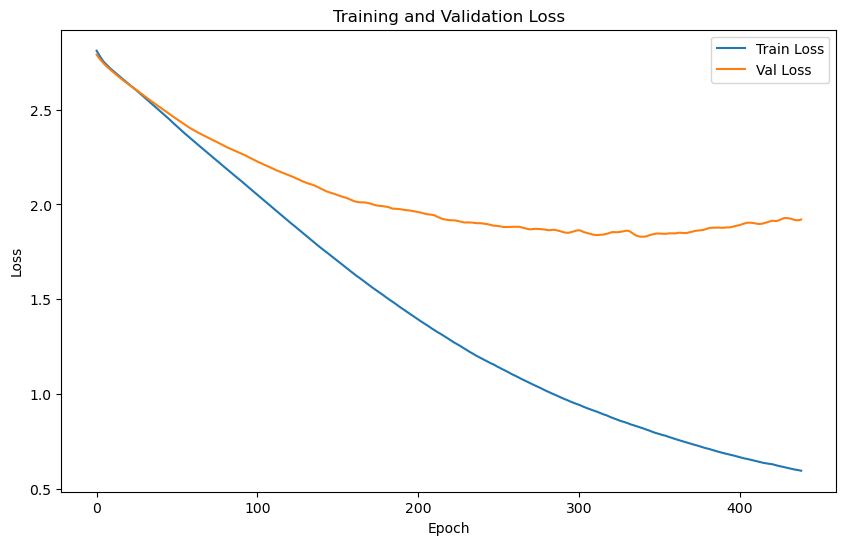

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.1127 | Test Accuracy: 45.45%


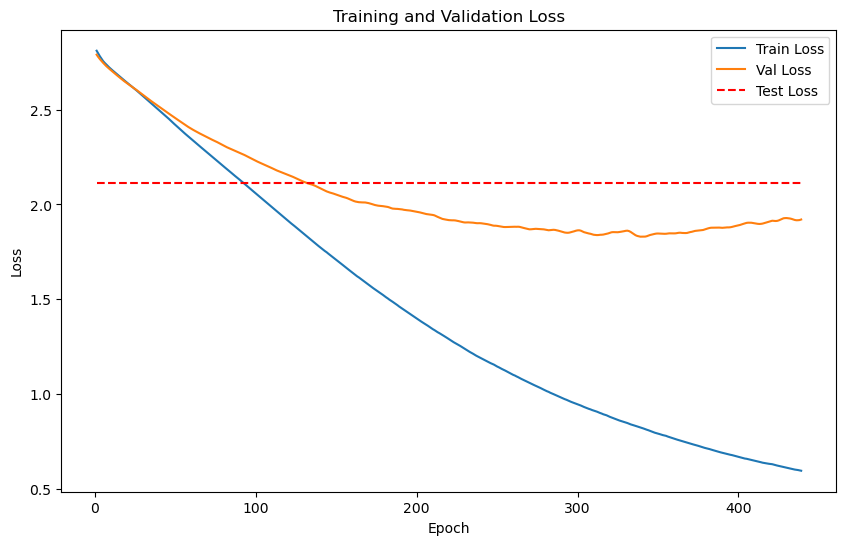

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10089, 64), 
Test labels shape: (10089,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5026
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5027
    Batch [2/2], Val Loss: 0.3608
Epoch [1/2000], Avg Train Loss: 0.5026, Avg Val Loss: 0.4317

Validation loss improved from inf to 0.4317. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.5083
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.3598
Epoch [2/2000], Avg Train Loss: 0.5083, Avg Val Loss: 0.4305

Validation loss improved from 0.4317 to 0.4305. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.5078
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4996
    Batch [2/2], Val Loss: 0.3588
Epoch [3/2000], Avg Train Loss: 0.5078, Avg Val Loss: 0.4292

Validation loss improved from 0.4305 to 0.4292. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.5104
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4983
    Batch [2/2], Val Loss: 0.3581
Epoch [4/2000], Avg Train Loss: 0.5104, Avg Val Loss: 0.4282

Validation loss improved from 0.4292 to 0.4282. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5067
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4972
    Batch [2/2], Val Loss: 0.3574
Epoch [5/2000], Avg Train Loss: 0.5067, Avg Val Loss: 0.4273

Validation loss improved from 0.4282 to 0.4273. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.5036
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.3571
Epoch [6/2000], Avg Train Loss: 0.5036, Avg Val Loss: 0.4265

Validation loss improved from 0.4273 to 0.4265. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.5001
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.4943
    Batch [2/2], Val Loss: 0.3569
Epoch [7/2000], Avg Train Loss: 0.5001, Avg Val Loss: 0.4256

Validation loss improved from 0.4265 to 0.4256. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4998
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.3568
Epoch [8/2000], Avg Train Loss: 0.4998, Avg Val Loss: 0.4249

Validation loss improved from 0.4256 to 0.4249. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4916
    Batch [2/2], Val Loss: 0.3566
Epoch [9/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.4241

Validation loss improved from 0.4249 to 0.4241. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.5002
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.3567
Epoch [10/2000], Avg Train Loss: 0.5002, Avg Val Loss: 0.4235

Validation loss improved from 0.4241 to 0.4235. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4891
    Batch [2/2], Val Loss: 0.3568
Epoch [11/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.4229

Validation loss improved from 0.4235 to 0.4229. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.5060
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4883
    Batch [2/2], Val Loss: 0.3569
Epoch [12/2000], Avg Train Loss: 0.5060, Avg Val Loss: 0.4226

Validation loss improved from 0.4229 to 0.4226. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4990
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4876
    Batch [2/2], Val Loss: 0.3570
Epoch [13/2000], Avg Train Loss: 0.4990, Avg Val Loss: 0.4223

Validation loss improved from 0.4226 to 0.4223. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.5019
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4871
    Batch [2/2], Val Loss: 0.3573
Epoch [14/2000], Avg Train Loss: 0.5019, Avg Val Loss: 0.4222

Validation loss improved from 0.4223 to 0.4222. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4972
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.3577
Epoch [15/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.4221

Validation loss improved from 0.4222 to 0.4221. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4971
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4854
    Batch [2/2], Val Loss: 0.3582
Epoch [16/2000], Avg Train Loss: 0.4971, Avg Val Loss: 0.4218

Validation loss improved from 0.4221 to 0.4218. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4955
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4844
    Batch [2/2], Val Loss: 0.3587
Epoch [17/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.4216

Validation loss improved from 0.4218 to 0.4216. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4994
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4835
    Batch [2/2], Val Loss: 0.3591
Epoch [18/2000], Avg Train Loss: 0.4994, Avg Val Loss: 0.4213

Validation loss improved from 0.4216 to 0.4213. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4976
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4824
    Batch [2/2], Val Loss: 0.3594
Epoch [19/2000], Avg Train Loss: 0.4976, Avg Val Loss: 0.4209

Validation loss improved from 0.4213 to 0.4209. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4814
    Batch [2/2], Val Loss: 0.3598
Epoch [20/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.4206

Validation loss improved from 0.4209 to 0.4206. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4964
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.3602
Epoch [21/2000], Avg Train Loss: 0.4964, Avg Val Loss: 0.4203

Validation loss improved from 0.4206 to 0.4203. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.3607
Epoch [22/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.4200

Validation loss improved from 0.4203 to 0.4200. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.3611
Epoch [23/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.4199

Validation loss improved from 0.4200 to 0.4199. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.3615
Epoch [24/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.4198

Validation loss improved from 0.4199 to 0.4198. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.3619
Epoch [25/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.4197

Validation loss improved from 0.4198 to 0.4197. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4954
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.3623
Epoch [26/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.4196

Validation loss improved from 0.4197 to 0.4196. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.3626
Epoch [27/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.4195

Validation loss improved from 0.4196 to 0.4195. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.3630
Epoch [28/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4195

Validation loss improved from 0.4195 to 0.4195. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4756
    Batch [2/2], Val Loss: 0.3633
Epoch [29/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4194

Validation loss improved from 0.4195 to 0.4194. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4752
    Batch [2/2], Val Loss: 0.3637
Epoch [30/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.4194

Validation loss improved from 0.4194 to 0.4194. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4749
    Batch [2/2], Val Loss: 0.3640
Epoch [31/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4194

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4745
    Batch [2/2], Val Loss: 0.3644
Epoch [32/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.4195

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4742
    Batch [2/2], Val Loss: 0.3649
Epoch [33/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4195

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4738
    Batch [2/2], Val Loss: 0.3654
Epoch [34/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4196

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4736
    Batch [2/2], Val Loss: 0.3658
Epoch [35/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.4197

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4733
    Batch [2/2], Val Loss: 0.3664
Epoch [36/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4199

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.3671
Epoch [37/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4201

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.3678
Epoch [38/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.4203

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4725
    Batch [2/2], Val Loss: 0.3684
Epoch [39/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4205

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4722
    Batch [2/2], Val Loss: 0.3691
Epoch [40/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4207

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4720
    Batch [2/2], Val Loss: 0.3697
Epoch [41/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4208

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4717
    Batch [2/2], Val Loss: 0.3703
Epoch [42/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4210

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.3708
Epoch [43/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4211

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.3713
Epoch [44/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4213

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.3717
Epoch [45/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4214

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4707
    Batch [2/2], Val Loss: 0.3722
Epoch [46/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4215

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.3727
Epoch [47/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4216

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.3732
Epoch [48/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4217

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.3736
Epoch [49/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4218

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.3740
Epoch [50/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4219

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4773
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.3744
Epoch [51/2000], Avg Train Loss: 0.4773, Avg Val Loss: 0.4220

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.3748
Epoch [52/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4221

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.3750
Epoch [53/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4221

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4690
    Batch [2/2], Val Loss: 0.3753
Epoch [54/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4222

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4758
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.3755
Epoch [55/2000], Avg Train Loss: 0.4758, Avg Val Loss: 0.4222

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4766
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.3757
Epoch [56/2000], Avg Train Loss: 0.4766, Avg Val Loss: 0.4223

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.3758
Epoch [57/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4223

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.3759
Epoch [58/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4223

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4701
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.3760
Epoch [59/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.4224

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.3761
Epoch [60/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4224

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.3762
Epoch [61/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.4225

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4765
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.3763
Epoch [62/2000], Avg Train Loss: 0.4765, Avg Val Loss: 0.4225

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.3763
Epoch [63/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4225

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.3764
Epoch [64/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4226

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.3765
Epoch [65/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4226

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.3765
Epoch [66/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.4226

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.3766
Epoch [67/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4226

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.3766
Epoch [68/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4227

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.3767
Epoch [69/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4227

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.3767
Epoch [70/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4227

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.3768
Epoch [71/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.4227

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.3768
Epoch [72/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.4227

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.3769
Epoch [73/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4227

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.3769
Epoch [74/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4227

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.3769
Epoch [75/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.4227

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4763
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.3769
Epoch [76/2000], Avg Train Loss: 0.4763, Avg Val Loss: 0.4227

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.3770
Epoch [77/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.4227

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4723
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.3770
Epoch [78/2000], Avg Train Loss: 0.4723, Avg Val Loss: 0.4227

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.3770
Epoch [79/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4227

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.3770
Epoch [80/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3771
Epoch [81/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3771
Epoch [82/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3771
Epoch [83/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3771
Epoch [84/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4755
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3771
Epoch [85/2000], Avg Train Loss: 0.4755, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3771
Epoch [86/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3771
Epoch [87/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4723
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3771
Epoch [88/2000], Avg Train Loss: 0.4723, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4758
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [89/2000], Avg Train Loss: 0.4758, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4736
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [90/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4788
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [91/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [92/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [93/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4760
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [94/2000], Avg Train Loss: 0.4760, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4779
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [95/2000], Avg Train Loss: 0.4779, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [96/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [97/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [98/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [99/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [100/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [101/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [102/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [103/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [104/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [105/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [106/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [107/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4726
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [108/2000], Avg Train Loss: 0.4726, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [109/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [110/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4763
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [111/2000], Avg Train Loss: 0.4763, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [112/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4758
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [113/2000], Avg Train Loss: 0.4758, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4763
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [114/2000], Avg Train Loss: 0.4763, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [115/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [116/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4698
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [117/2000], Avg Train Loss: 0.4698, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [118/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4757
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [119/2000], Avg Train Loss: 0.4757, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4759
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [120/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [121/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [122/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [123/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [124/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4774
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [125/2000], Avg Train Loss: 0.4774, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4767
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [126/2000], Avg Train Loss: 0.4767, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [127/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [128/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4756
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [129/2000], Avg Train Loss: 0.4756, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3772
Epoch [130/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4228

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 130!!
No improvement for 100 epochs


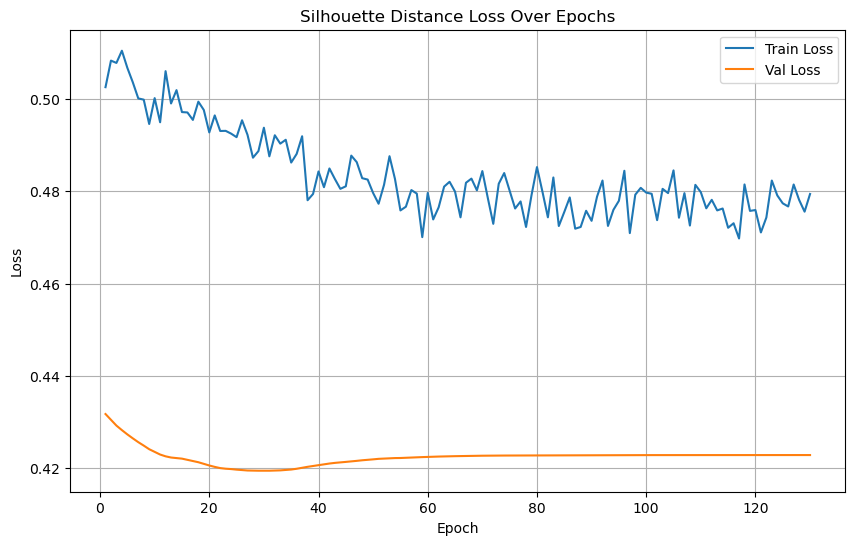

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/158], Loss: 0.4581
Test Batch [20/158], Loss: 0.3890
Test Batch [30/158], Loss: 0.4308


Test Batch [40/158], Loss: 0.3266
Test Batch [50/158], Loss: 0.4117
Test Batch [60/158], Loss: 0.4007


Test Batch [70/158], Loss: 0.2110
Test Batch [80/158], Loss: 0.2343
Test Batch [90/158], Loss: 0.2537
Test Batch [100/158], Loss: 0.2492
Test Batch [110/158], Loss: 0.2837


Test Batch [120/158], Loss: 0.2261
Test Batch [130/158], Loss: 0.5000
Test Batch [140/158], Loss: 0.4101
Test Batch [150/158], Loss: 0.3272



Test Loss: 0.3327


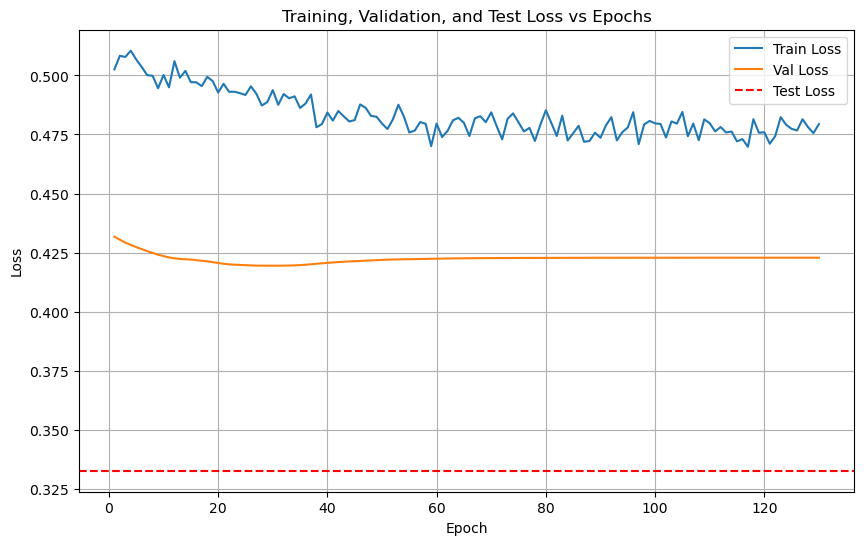

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/158 for test dataset.


  Processed batch 20/158 for test dataset.


  Processed batch 30/158 for test dataset.
  Processed batch 40/158 for test dataset.


  Processed batch 50/158 for test dataset.


  Processed batch 60/158 for test dataset.
  Processed batch 70/158 for test dataset.
  Processed batch 80/158 for test dataset.


  Processed batch 90/158 for test dataset.
  Processed batch 100/158 for test dataset.
  Processed batch 110/158 for test dataset.


  Processed batch 120/158 for test dataset.
  Processed batch 130/158 for test dataset.


  Processed batch 140/158 for test dataset.
  Processed batch 150/158 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 58.75%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.50      0.40      0.44         5
           2       0.00      0.00      0.00         5
           3       1.00      0.80      0.89         5
           4       0.80      0.80      0.80         5
           5       0.80      0.80      0.80         5
           6       0.62      1.00      0.77         5
           7       0.25      0.40      0.31         5
           8       1.00      1.00      1.00         5
           9       0.40      0.40      0.40         5
          10       0.33      0.20      0.25         5
          11       0.38      0.60      0.46         5
          12       0.50      1.00      0.67         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7683  |  Val Loss: 2.7801
Validation loss improved from inf to 2.7801.
[Epoch 2/1000] Train Loss: 2.7622  |  Val Loss: 2.7759
Validation loss improved from 2.7801 to 2.7759.
[Epoch 3/1000] Train Loss: 2.7567  |  Val Loss: 2.7718
Validation loss improved from 2.7759 to 2.7718.
[Epoch 4/1000] Train Loss: 2.7514  |  Val Loss: 2.7677
Validation loss improved from 2.7718 to 2.7677.
[Epoch 5/1000] Train Loss: 2.7463  |  Val Loss: 2.7637
Validation loss improved from 2.7677 to 2.7637.
[Epoch 6/1000] Train Loss: 2.7410  |  Val Loss: 2.7595
Validation loss improved from 2.7637 to 2.7595.
[Epoch 7/1000] Train Loss: 2.7360  |  Val Loss: 2.7553
Validation loss improved from 2.7595 to 2.7553.
[Epoch 8/1000] Train Loss: 2.7310  |  Val Loss: 2.7513
Validation loss improved from 2.7553 to 2.7513.
[Epoch 9/1000] Train Loss: 2.7260  |  Val Loss: 2.7475
Validation loss improved from 2.7513 to 2.7475.
[Epoch 10/1000] Train Loss: 2.7213  |  Val Loss: 2.7438
Validation loss impr

[Epoch 20/1000] Train Loss: 2.6751  |  Val Loss: 2.7100
Validation loss improved from 2.7133 to 2.7100.
[Epoch 21/1000] Train Loss: 2.6707  |  Val Loss: 2.7068
Validation loss improved from 2.7100 to 2.7068.
[Epoch 22/1000] Train Loss: 2.6662  |  Val Loss: 2.7037
Validation loss improved from 2.7068 to 2.7037.
[Epoch 23/1000] Train Loss: 2.6616  |  Val Loss: 2.7006
Validation loss improved from 2.7037 to 2.7006.
[Epoch 24/1000] Train Loss: 2.6572  |  Val Loss: 2.6973
Validation loss improved from 2.7006 to 2.6973.
[Epoch 25/1000] Train Loss: 2.6525  |  Val Loss: 2.6940
Validation loss improved from 2.6973 to 2.6940.
[Epoch 26/1000] Train Loss: 2.6482  |  Val Loss: 2.6907
Validation loss improved from 2.6940 to 2.6907.
[Epoch 27/1000] Train Loss: 2.6436  |  Val Loss: 2.6874
Validation loss improved from 2.6907 to 2.6874.
[Epoch 28/1000] Train Loss: 2.6391  |  Val Loss: 2.6841
Validation loss improved from 2.6874 to 2.6841.
[Epoch 29/1000] Train Loss: 2.6345  |  Val Loss: 2.6807
Validati

[Epoch 37/1000] Train Loss: 2.5983  |  Val Loss: 2.6538
Validation loss improved from 2.6572 to 2.6538.
[Epoch 38/1000] Train Loss: 2.5937  |  Val Loss: 2.6505
Validation loss improved from 2.6538 to 2.6505.
[Epoch 39/1000] Train Loss: 2.5888  |  Val Loss: 2.6473
Validation loss improved from 2.6505 to 2.6473.
[Epoch 40/1000] Train Loss: 2.5841  |  Val Loss: 2.6440
Validation loss improved from 2.6473 to 2.6440.
[Epoch 41/1000] Train Loss: 2.5794  |  Val Loss: 2.6407
Validation loss improved from 2.6440 to 2.6407.
[Epoch 42/1000] Train Loss: 2.5744  |  Val Loss: 2.6374
Validation loss improved from 2.6407 to 2.6374.
[Epoch 43/1000] Train Loss: 2.5698  |  Val Loss: 2.6341
Validation loss improved from 2.6374 to 2.6341.
[Epoch 44/1000] Train Loss: 2.5651  |  Val Loss: 2.6310
Validation loss improved from 2.6341 to 2.6310.
[Epoch 45/1000] Train Loss: 2.5604  |  Val Loss: 2.6278
Validation loss improved from 2.6310 to 2.6278.
[Epoch 46/1000] Train Loss: 2.5556  |  Val Loss: 2.6245
Validati

[Epoch 61/1000] Train Loss: 2.4805  |  Val Loss: 2.5697
Validation loss improved from 2.5735 to 2.5697.
[Epoch 62/1000] Train Loss: 2.4751  |  Val Loss: 2.5659
Validation loss improved from 2.5697 to 2.5659.
[Epoch 63/1000] Train Loss: 2.4699  |  Val Loss: 2.5622
Validation loss improved from 2.5659 to 2.5622.
[Epoch 64/1000] Train Loss: 2.4644  |  Val Loss: 2.5586
Validation loss improved from 2.5622 to 2.5586.
[Epoch 65/1000] Train Loss: 2.4593  |  Val Loss: 2.5549
Validation loss improved from 2.5586 to 2.5549.
[Epoch 66/1000] Train Loss: 2.4537  |  Val Loss: 2.5511
Validation loss improved from 2.5549 to 2.5511.
[Epoch 67/1000] Train Loss: 2.4481  |  Val Loss: 2.5474
Validation loss improved from 2.5511 to 2.5474.
[Epoch 68/1000] Train Loss: 2.4427  |  Val Loss: 2.5437
Validation loss improved from 2.5474 to 2.5437.
[Epoch 69/1000] Train Loss: 2.4370  |  Val Loss: 2.5398
Validation loss improved from 2.5437 to 2.5398.
[Epoch 70/1000] Train Loss: 2.4318  |  Val Loss: 2.5359
Validati

[Epoch 76/1000] Train Loss: 2.3976  |  Val Loss: 2.5125
Validation loss improved from 2.5165 to 2.5125.
[Epoch 77/1000] Train Loss: 2.3915  |  Val Loss: 2.5083
Validation loss improved from 2.5125 to 2.5083.
[Epoch 78/1000] Train Loss: 2.3854  |  Val Loss: 2.5041
Validation loss improved from 2.5083 to 2.5041.
[Epoch 79/1000] Train Loss: 2.3793  |  Val Loss: 2.4999
Validation loss improved from 2.5041 to 2.4999.
[Epoch 80/1000] Train Loss: 2.3735  |  Val Loss: 2.4957
Validation loss improved from 2.4999 to 2.4957.
[Epoch 81/1000] Train Loss: 2.3671  |  Val Loss: 2.4916
Validation loss improved from 2.4957 to 2.4916.
[Epoch 82/1000] Train Loss: 2.3612  |  Val Loss: 2.4875
Validation loss improved from 2.4916 to 2.4875.
[Epoch 83/1000] Train Loss: 2.3552  |  Val Loss: 2.4835
Validation loss improved from 2.4875 to 2.4835.
[Epoch 84/1000] Train Loss: 2.3492  |  Val Loss: 2.4794
Validation loss improved from 2.4835 to 2.4794.
[Epoch 85/1000] Train Loss: 2.3430  |  Val Loss: 2.4753
Validati

[Epoch 102/1000] Train Loss: 2.2376  |  Val Loss: 2.4047
Validation loss improved from 2.4089 to 2.4047.
[Epoch 103/1000] Train Loss: 2.2314  |  Val Loss: 2.4005
Validation loss improved from 2.4047 to 2.4005.
[Epoch 104/1000] Train Loss: 2.2251  |  Val Loss: 2.3962
Validation loss improved from 2.4005 to 2.3962.
[Epoch 105/1000] Train Loss: 2.2190  |  Val Loss: 2.3919
Validation loss improved from 2.3962 to 2.3919.
[Epoch 106/1000] Train Loss: 2.2126  |  Val Loss: 2.3877
Validation loss improved from 2.3919 to 2.3877.
[Epoch 107/1000] Train Loss: 2.2062  |  Val Loss: 2.3836
Validation loss improved from 2.3877 to 2.3836.
[Epoch 108/1000] Train Loss: 2.1998  |  Val Loss: 2.3795
Validation loss improved from 2.3836 to 2.3795.
[Epoch 109/1000] Train Loss: 2.1937  |  Val Loss: 2.3754
Validation loss improved from 2.3795 to 2.3754.
[Epoch 110/1000] Train Loss: 2.1871  |  Val Loss: 2.3714
Validation loss improved from 2.3754 to 2.3714.
[Epoch 111/1000] Train Loss: 2.1810  |  Val Loss: 2.367

[Epoch 116/1000] Train Loss: 2.1486  |  Val Loss: 2.3472
Validation loss improved from 2.3511 to 2.3472.
[Epoch 117/1000] Train Loss: 2.1419  |  Val Loss: 2.3432
Validation loss improved from 2.3472 to 2.3432.
[Epoch 118/1000] Train Loss: 2.1352  |  Val Loss: 2.3393
Validation loss improved from 2.3432 to 2.3393.
[Epoch 119/1000] Train Loss: 2.1286  |  Val Loss: 2.3354
Validation loss improved from 2.3393 to 2.3354.
[Epoch 120/1000] Train Loss: 2.1218  |  Val Loss: 2.3315
Validation loss improved from 2.3354 to 2.3315.
[Epoch 121/1000] Train Loss: 2.1151  |  Val Loss: 2.3278
Validation loss improved from 2.3315 to 2.3278.
[Epoch 122/1000] Train Loss: 2.1085  |  Val Loss: 2.3241
Validation loss improved from 2.3278 to 2.3241.
[Epoch 123/1000] Train Loss: 2.1017  |  Val Loss: 2.3208
Validation loss improved from 2.3241 to 2.3208.
[Epoch 124/1000] Train Loss: 2.0952  |  Val Loss: 2.3178
Validation loss improved from 2.3208 to 2.3178.
[Epoch 125/1000] Train Loss: 2.0881  |  Val Loss: 2.314

[Epoch 141/1000] Train Loss: 1.9839  |  Val Loss: 2.2599
Validation loss improved from 2.2636 to 2.2599.
[Epoch 142/1000] Train Loss: 1.9772  |  Val Loss: 2.2560
Validation loss improved from 2.2599 to 2.2560.
[Epoch 143/1000] Train Loss: 1.9703  |  Val Loss: 2.2523
Validation loss improved from 2.2560 to 2.2523.
[Epoch 144/1000] Train Loss: 1.9635  |  Val Loss: 2.2485
Validation loss improved from 2.2523 to 2.2485.
[Epoch 145/1000] Train Loss: 1.9568  |  Val Loss: 2.2448
Validation loss improved from 2.2485 to 2.2448.
[Epoch 146/1000] Train Loss: 1.9499  |  Val Loss: 2.2411
Validation loss improved from 2.2448 to 2.2411.
[Epoch 147/1000] Train Loss: 1.9432  |  Val Loss: 2.2375
Validation loss improved from 2.2411 to 2.2375.
[Epoch 148/1000] Train Loss: 1.9364  |  Val Loss: 2.2339
Validation loss improved from 2.2375 to 2.2339.
[Epoch 149/1000] Train Loss: 1.9295  |  Val Loss: 2.2300
Validation loss improved from 2.2339 to 2.2300.
[Epoch 150/1000] Train Loss: 1.9228  |  Val Loss: 2.226

[Epoch 154/1000] Train Loss: 1.8953  |  Val Loss: 2.2103
Validation loss improved from 2.2143 to 2.2103.
[Epoch 155/1000] Train Loss: 1.8883  |  Val Loss: 2.2058
Validation loss improved from 2.2103 to 2.2058.
[Epoch 156/1000] Train Loss: 1.8816  |  Val Loss: 2.2011
Validation loss improved from 2.2058 to 2.2011.
[Epoch 157/1000] Train Loss: 1.8747  |  Val Loss: 2.1967
Validation loss improved from 2.2011 to 2.1967.
[Epoch 158/1000] Train Loss: 1.8678  |  Val Loss: 2.1926
Validation loss improved from 2.1967 to 2.1926.
[Epoch 159/1000] Train Loss: 1.8608  |  Val Loss: 2.1889
Validation loss improved from 2.1926 to 2.1889.
[Epoch 160/1000] Train Loss: 1.8540  |  Val Loss: 2.1854
Validation loss improved from 2.1889 to 2.1854.
[Epoch 161/1000] Train Loss: 1.8471  |  Val Loss: 2.1816
Validation loss improved from 2.1854 to 2.1816.
[Epoch 162/1000] Train Loss: 1.8403  |  Val Loss: 2.1777
Validation loss improved from 2.1816 to 2.1777.
[Epoch 163/1000] Train Loss: 1.8332  |  Val Loss: 2.174

[Epoch 184/1000] Train Loss: 1.6903  |  Val Loss: 2.1007
Validation loss improved from 2.1037 to 2.1007.
[Epoch 185/1000] Train Loss: 1.6835  |  Val Loss: 2.0980
Validation loss improved from 2.1007 to 2.0980.
[Epoch 186/1000] Train Loss: 1.6769  |  Val Loss: 2.0955
Validation loss improved from 2.0980 to 2.0955.
[Epoch 187/1000] Train Loss: 1.6702  |  Val Loss: 2.0931
Validation loss improved from 2.0955 to 2.0931.
[Epoch 188/1000] Train Loss: 1.6633  |  Val Loss: 2.0904
Validation loss improved from 2.0931 to 2.0904.
[Epoch 189/1000] Train Loss: 1.6564  |  Val Loss: 2.0876
Validation loss improved from 2.0904 to 2.0876.
[Epoch 190/1000] Train Loss: 1.6493  |  Val Loss: 2.0849
Validation loss improved from 2.0876 to 2.0849.
[Epoch 191/1000] Train Loss: 1.6426  |  Val Loss: 2.0815
Validation loss improved from 2.0849 to 2.0815.
[Epoch 192/1000] Train Loss: 1.6357  |  Val Loss: 2.0776
Validation loss improved from 2.0815 to 2.0776.
[Epoch 193/1000] Train Loss: 1.6284  |  Val Loss: 2.073

[Epoch 195/1000] Train Loss: 1.6144  |  Val Loss: 2.0660
Validation loss improved from 2.0699 to 2.0660.
[Epoch 196/1000] Train Loss: 1.6076  |  Val Loss: 2.0623
Validation loss improved from 2.0660 to 2.0623.
[Epoch 197/1000] Train Loss: 1.6006  |  Val Loss: 2.0592
Validation loss improved from 2.0623 to 2.0592.
[Epoch 198/1000] Train Loss: 1.5937  |  Val Loss: 2.0560
Validation loss improved from 2.0592 to 2.0560.
[Epoch 199/1000] Train Loss: 1.5868  |  Val Loss: 2.0521
Validation loss improved from 2.0560 to 2.0521.
[Epoch 200/1000] Train Loss: 1.5796  |  Val Loss: 2.0476
Validation loss improved from 2.0521 to 2.0476.
[Epoch 201/1000] Train Loss: 1.5727  |  Val Loss: 2.0430
Validation loss improved from 2.0476 to 2.0430.
[Epoch 202/1000] Train Loss: 1.5659  |  Val Loss: 2.0387
Validation loss improved from 2.0430 to 2.0387.
[Epoch 203/1000] Train Loss: 1.5588  |  Val Loss: 2.0349
Validation loss improved from 2.0387 to 2.0349.
[Epoch 204/1000] Train Loss: 1.5522  |  Val Loss: 2.031

[Epoch 222/1000] Train Loss: 1.4266  |  Val Loss: 1.9794
Validation loss improved from 1.9820 to 1.9794.
[Epoch 223/1000] Train Loss: 1.4197  |  Val Loss: 1.9773
Validation loss improved from 1.9794 to 1.9773.
[Epoch 224/1000] Train Loss: 1.4128  |  Val Loss: 1.9752
Validation loss improved from 1.9773 to 1.9752.
[Epoch 225/1000] Train Loss: 1.4062  |  Val Loss: 1.9730
Validation loss improved from 1.9752 to 1.9730.
[Epoch 226/1000] Train Loss: 1.3995  |  Val Loss: 1.9716
Validation loss improved from 1.9730 to 1.9716.
[Epoch 227/1000] Train Loss: 1.3927  |  Val Loss: 1.9707
Validation loss improved from 1.9716 to 1.9707.
[Epoch 228/1000] Train Loss: 1.3861  |  Val Loss: 1.9692
Validation loss improved from 1.9707 to 1.9692.
[Epoch 229/1000] Train Loss: 1.3796  |  Val Loss: 1.9676
Validation loss improved from 1.9692 to 1.9676.
[Epoch 230/1000] Train Loss: 1.3729  |  Val Loss: 1.9667
Validation loss improved from 1.9676 to 1.9667.
[Epoch 231/1000] Train Loss: 1.3667  |  Val Loss: 1.966

[Epoch 235/1000] Train Loss: 1.3405  |  Val Loss: 1.9577
Validation loss improved from 1.9603 to 1.9577.
[Epoch 236/1000] Train Loss: 1.3340  |  Val Loss: 1.9542
Validation loss improved from 1.9577 to 1.9542.
[Epoch 237/1000] Train Loss: 1.3274  |  Val Loss: 1.9496
Validation loss improved from 1.9542 to 1.9496.
[Epoch 238/1000] Train Loss: 1.3212  |  Val Loss: 1.9459
Validation loss improved from 1.9496 to 1.9459.
[Epoch 239/1000] Train Loss: 1.3149  |  Val Loss: 1.9435
Validation loss improved from 1.9459 to 1.9435.
[Epoch 240/1000] Train Loss: 1.3085  |  Val Loss: 1.9416
Validation loss improved from 1.9435 to 1.9416.
[Epoch 241/1000] Train Loss: 1.3023  |  Val Loss: 1.9403
Validation loss improved from 1.9416 to 1.9403.
[Epoch 242/1000] Train Loss: 1.2960  |  Val Loss: 1.9388
Validation loss improved from 1.9403 to 1.9388.
[Epoch 243/1000] Train Loss: 1.2899  |  Val Loss: 1.9369
Validation loss improved from 1.9388 to 1.9369.
[Epoch 244/1000] Train Loss: 1.2837  |  Val Loss: 1.934

[Epoch 268/1000] Train Loss: 1.1443  |  Val Loss: 1.8761
Validation loss improved from 1.8785 to 1.8761.
[Epoch 269/1000] Train Loss: 1.1389  |  Val Loss: 1.8737
Validation loss improved from 1.8761 to 1.8737.
[Epoch 270/1000] Train Loss: 1.1333  |  Val Loss: 1.8717
Validation loss improved from 1.8737 to 1.8717.
[Epoch 271/1000] Train Loss: 1.1274  |  Val Loss: 1.8697
Validation loss improved from 1.8717 to 1.8697.
[Epoch 272/1000] Train Loss: 1.1216  |  Val Loss: 1.8689
Validation loss improved from 1.8697 to 1.8689.
[Epoch 273/1000] Train Loss: 1.1161  |  Val Loss: 1.8679
Validation loss improved from 1.8689 to 1.8679.
[Epoch 274/1000] Train Loss: 1.1103  |  Val Loss: 1.8665
Validation loss improved from 1.8679 to 1.8665.
[Epoch 275/1000] Train Loss: 1.1047  |  Val Loss: 1.8659
Validation loss improved from 1.8665 to 1.8659.
[Epoch 276/1000] Train Loss: 1.0991  |  Val Loss: 1.8658
Validation loss improved from 1.8659 to 1.8658.
[Epoch 277/1000] Train Loss: 1.0935  |  Val Loss: 1.866

[Epoch 279/1000] Train Loss: 1.0825  |  Val Loss: 1.8655
Validation loss improved from 1.8658 to 1.8655.
[Epoch 280/1000] Train Loss: 1.0767  |  Val Loss: 1.8645
Validation loss improved from 1.8655 to 1.8645.
[Epoch 281/1000] Train Loss: 1.0715  |  Val Loss: 1.8629
Validation loss improved from 1.8645 to 1.8629.
[Epoch 282/1000] Train Loss: 1.0659  |  Val Loss: 1.8619
Validation loss improved from 1.8629 to 1.8619.
[Epoch 283/1000] Train Loss: 1.0607  |  Val Loss: 1.8605
Validation loss improved from 1.8619 to 1.8605.
[Epoch 284/1000] Train Loss: 1.0554  |  Val Loss: 1.8584
Validation loss improved from 1.8605 to 1.8584.
[Epoch 285/1000] Train Loss: 1.0504  |  Val Loss: 1.8565
Validation loss improved from 1.8584 to 1.8565.
[Epoch 286/1000] Train Loss: 1.0448  |  Val Loss: 1.8560
Validation loss improved from 1.8565 to 1.8560.
[Epoch 287/1000] Train Loss: 1.0396  |  Val Loss: 1.8563
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 288/1000] Train Loss: 1.0346  |  Val Loss:

[Epoch 306/1000] Train Loss: 0.9455  |  Val Loss: 1.8373
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 307/1000] Train Loss: 0.9410  |  Val Loss: 1.8365
Validation loss improved from 1.8370 to 1.8365.
[Epoch 308/1000] Train Loss: 0.9361  |  Val Loss: 1.8358
Validation loss improved from 1.8365 to 1.8358.
[Epoch 309/1000] Train Loss: 0.9312  |  Val Loss: 1.8362
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 310/1000] Train Loss: 0.9268  |  Val Loss: 1.8360
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 311/1000] Train Loss: 0.9217  |  Val Loss: 1.8340
Validation loss improved from 1.8358 to 1.8340.
[Epoch 312/1000] Train Loss: 0.9173  |  Val Loss: 1.8319
Validation loss improved from 1.8340 to 1.8319.
[Epoch 313/1000] Train Loss: 0.9125  |  Val Loss: 1.8297
Validation loss improved from 1.8319 to 1.8297.
[Epoch 314/1000] Train Loss: 0.9077  |  Val Loss: 1.8274
Validation loss improved from 1.8297 to 1.8274.
[Epoch 315/1000] Train Loss: 0.9032  

[Epoch 319/1000] Train Loss: 0.8854  |  Val Loss: 1.8213
Validation loss improved from 1.8215 to 1.8213.
[Epoch 320/1000] Train Loss: 0.8810  |  Val Loss: 1.8220
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 321/1000] Train Loss: 0.8768  |  Val Loss: 1.8233
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 322/1000] Train Loss: 0.8722  |  Val Loss: 1.8241
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 323/1000] Train Loss: 0.8681  |  Val Loss: 1.8242
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 324/1000] Train Loss: 0.8636  |  Val Loss: 1.8237
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 325/1000] Train Loss: 0.8592  |  Val Loss: 1.8236
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 326/1000] Train Loss: 0.8549  |  Val Loss: 1.8234
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 327/1000] Train Loss: 0.8506  |  Val Loss: 1.8236
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 346/1000] Train Loss: 0.7723  |  Val Loss: 1.8121
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 347/1000] Train Loss: 0.7683  |  Val Loss: 1.8119
Validation loss improved from 1.8121 to 1.8119.
[Epoch 348/1000] Train Loss: 0.7642  |  Val Loss: 1.8115
Validation loss improved from 1.8119 to 1.8115.
[Epoch 349/1000] Train Loss: 0.7606  |  Val Loss: 1.8103
Validation loss improved from 1.8115 to 1.8103.
[Epoch 350/1000] Train Loss: 0.7568  |  Val Loss: 1.8084
Validation loss improved from 1.8103 to 1.8084.
[Epoch 351/1000] Train Loss: 0.7529  |  Val Loss: 1.8065
Validation loss improved from 1.8084 to 1.8065.
[Epoch 352/1000] Train Loss: 0.7489  |  Val Loss: 1.8055
Validation loss improved from 1.8065 to 1.8055.
[Epoch 353/1000] Train Loss: 0.7452  |  Val Loss: 1.8039
Validation loss improved from 1.8055 to 1.8039.
[Epoch 354/1000] Train Loss: 0.7412  |  Val Loss: 1.8015
Validation loss improved from 1.8039 to 1.8015.
[Epoch 355/1000] Train Loss: 0.7376  |  Val Loss:

[Epoch 360/1000] Train Loss: 0.7195  |  Val Loss: 1.7920
Validation loss improved from 1.7931 to 1.7920.
[Epoch 361/1000] Train Loss: 0.7161  |  Val Loss: 1.7906
Validation loss improved from 1.7920 to 1.7906.
[Epoch 362/1000] Train Loss: 0.7124  |  Val Loss: 1.7898
Validation loss improved from 1.7906 to 1.7898.
[Epoch 363/1000] Train Loss: 0.7089  |  Val Loss: 1.7880
Validation loss improved from 1.7898 to 1.7880.
[Epoch 364/1000] Train Loss: 0.7054  |  Val Loss: 1.7850
Validation loss improved from 1.7880 to 1.7850.
[Epoch 365/1000] Train Loss: 0.7018  |  Val Loss: 1.7814
Validation loss improved from 1.7850 to 1.7814.
[Epoch 366/1000] Train Loss: 0.6987  |  Val Loss: 1.7790
Validation loss improved from 1.7814 to 1.7790.
[Epoch 367/1000] Train Loss: 0.6952  |  Val Loss: 1.7794
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 368/1000] Train Loss: 0.6917  |  Val Loss: 1.7805
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 369/1000] Train Loss: 0.6881  |  Val

[Epoch 385/1000] Train Loss: 0.6346  |  Val Loss: 1.8043
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 386/1000] Train Loss: 0.6314  |  Val Loss: 1.8057
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 387/1000] Train Loss: 0.6283  |  Val Loss: 1.8064
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 388/1000] Train Loss: 0.6253  |  Val Loss: 1.8067
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 389/1000] Train Loss: 0.6222  |  Val Loss: 1.8071
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 390/1000] Train Loss: 0.6194  |  Val Loss: 1.8071
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 391/1000] Train Loss: 0.6162  |  Val Loss: 1.8070
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 392/1000] Train Loss: 0.6135  |  Val Loss: 1.8072
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 393/1000] Train Loss: 0.6108  |  Val Loss: 1.8069
!! Validation loss did NOT improve !! Patience:

[Epoch 399/1000] Train Loss: 0.5927  |  Val Loss: 1.7965
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 400/1000] Train Loss: 0.5896  |  Val Loss: 1.7994
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 401/1000] Train Loss: 0.5865  |  Val Loss: 1.8029
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 402/1000] Train Loss: 0.5835  |  Val Loss: 1.8067
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 403/1000] Train Loss: 0.5806  |  Val Loss: 1.8112
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 404/1000] Train Loss: 0.5776  |  Val Loss: 1.8158
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 405/1000] Train Loss: 0.5752  |  Val Loss: 1.8191
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 406/1000] Train Loss: 0.5722  |  Val Loss: 1.8208
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 407/1000] Train Loss: 0.5694  |  Val Loss: 1.8209
!! Validation loss did NOT improve !! Patience:

[Epoch 425/1000] Train Loss: 0.5208  |  Val Loss: 1.8151
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 426/1000] Train Loss: 0.5185  |  Val Loss: 1.8188
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 427/1000] Train Loss: 0.5162  |  Val Loss: 1.8234
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 428/1000] Train Loss: 0.5138  |  Val Loss: 1.8282
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 429/1000] Train Loss: 0.5115  |  Val Loss: 1.8328
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 430/1000] Train Loss: 0.5089  |  Val Loss: 1.8365
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 431/1000] Train Loss: 0.5065  |  Val Loss: 1.8402
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 432/1000] Train Loss: 0.5041  |  Val Loss: 1.8437
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 433/1000] Train Loss: 0.5017  |  Val Loss: 1.8466
!! Validation loss did NOT improve !! Patience:

[Epoch 440/1000] Train Loss: 0.4858  |  Val Loss: 1.8449
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 441/1000] Train Loss: 0.4833  |  Val Loss: 1.8439
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 442/1000] Train Loss: 0.4810  |  Val Loss: 1.8434
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 443/1000] Train Loss: 0.4790  |  Val Loss: 1.8431
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 444/1000] Train Loss: 0.4771  |  Val Loss: 1.8431
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 445/1000] Train Loss: 0.4746  |  Val Loss: 1.8449
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 446/1000] Train Loss: 0.4726  |  Val Loss: 1.8479
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 447/1000] Train Loss: 0.4704  |  Val Loss: 1.8520
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 448/1000] Train Loss: 0.4682  |  Val Loss: 1.8561
!! Validation loss did NOT improve !! Patience:

[Epoch 465/1000] Train Loss: 0.4359  |  Val Loss: 1.8651
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 466/1000] Train Loss: 0.4339  |  Val Loss: 1.8659
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 466 !!
No improvement for 100 epochs.


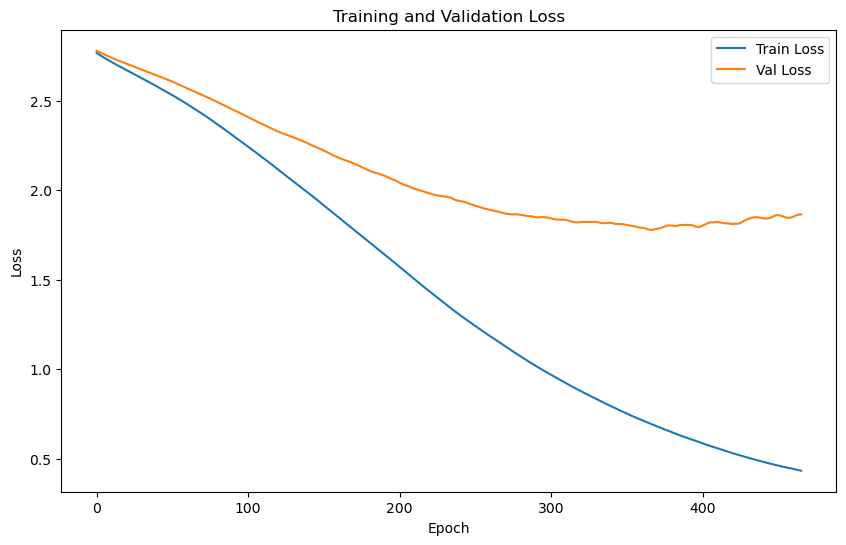

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.4156 | Test Accuracy: 43.01%


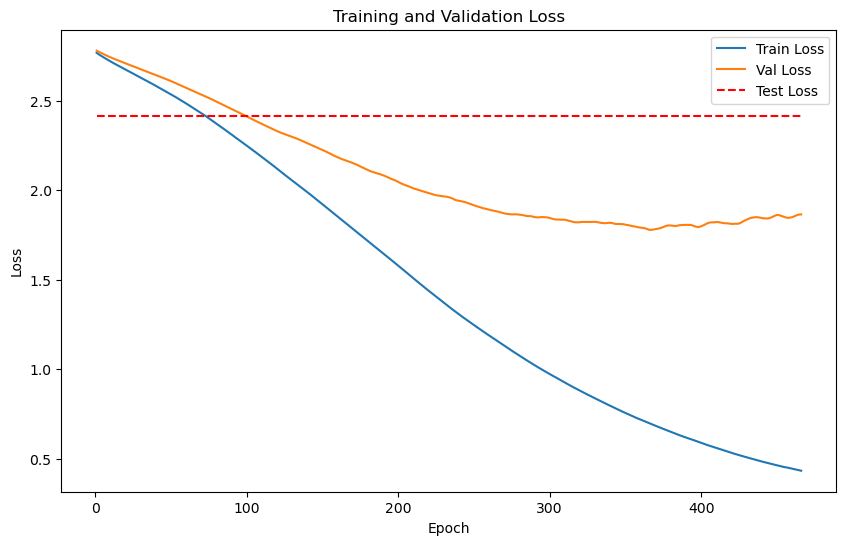

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


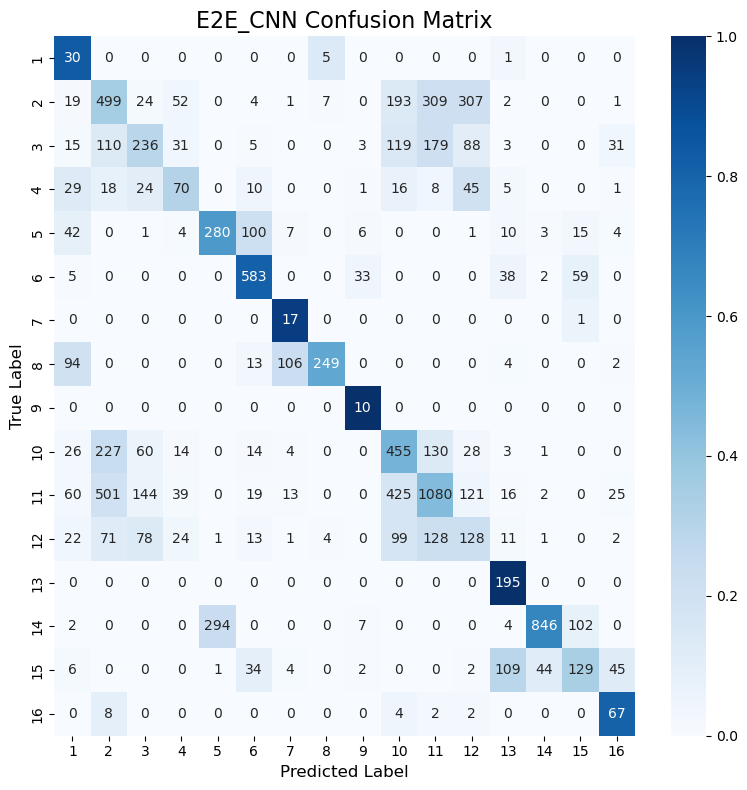

Classification Accuracy: 48.31%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


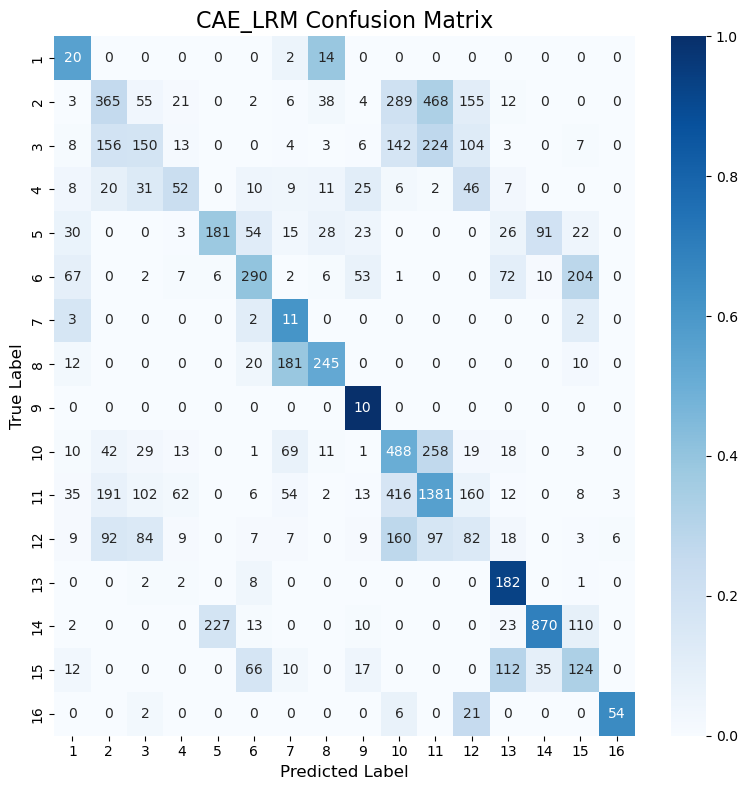

Classification Accuracy: 44.65%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


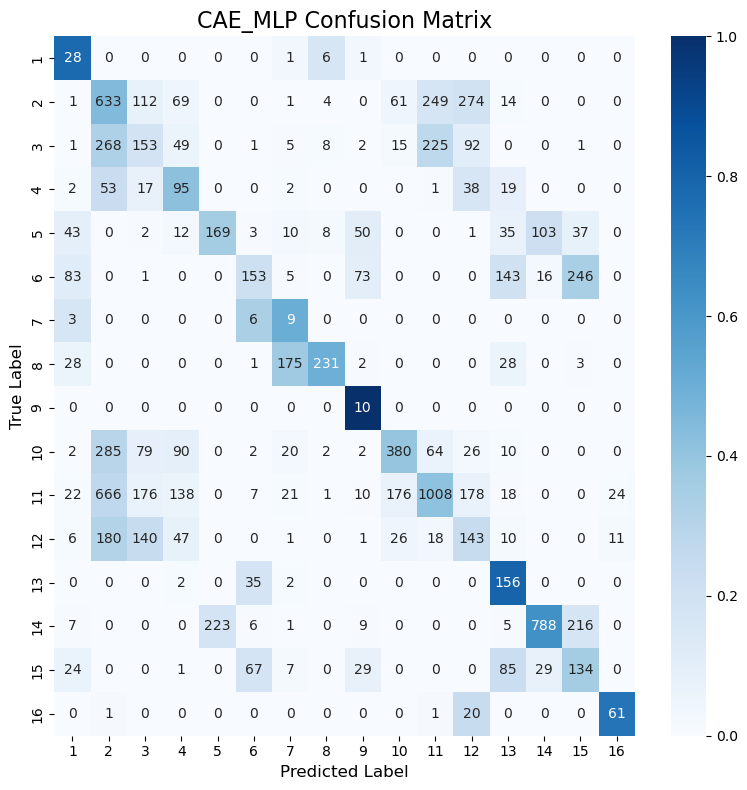

Classification Accuracy: 41.14%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


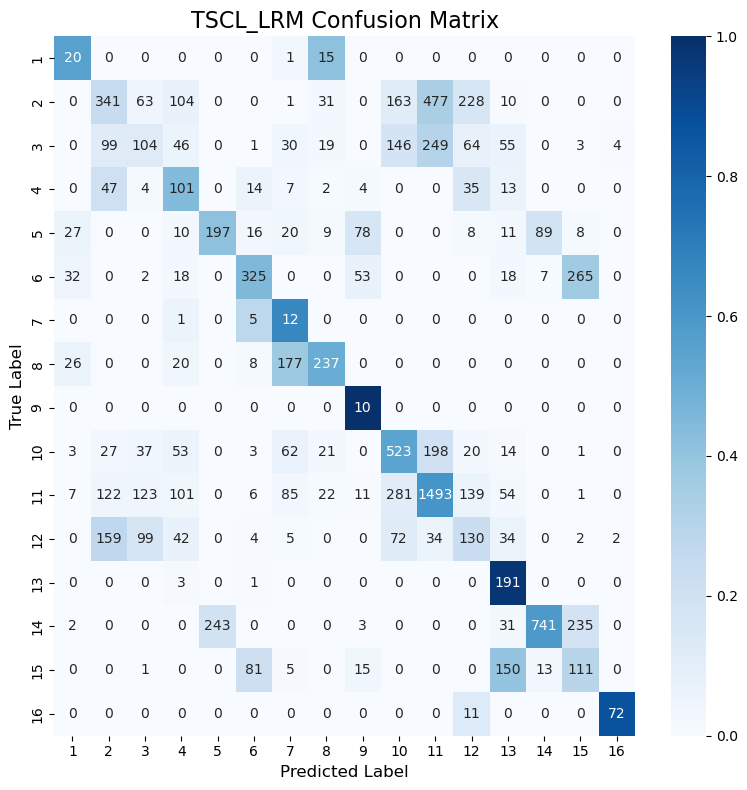

Classification Accuracy: 45.67%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


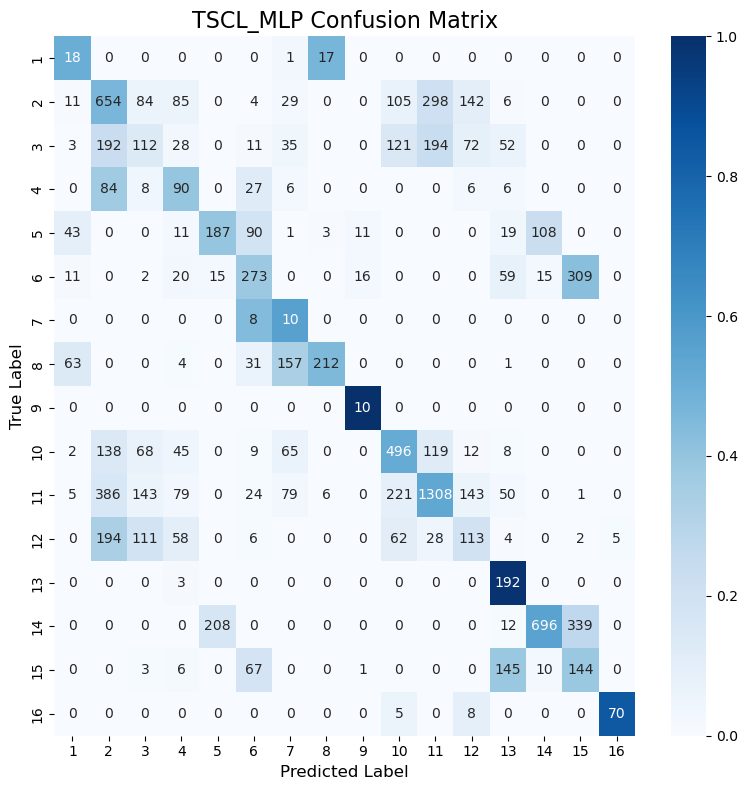

Classification Accuracy: 45.45%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


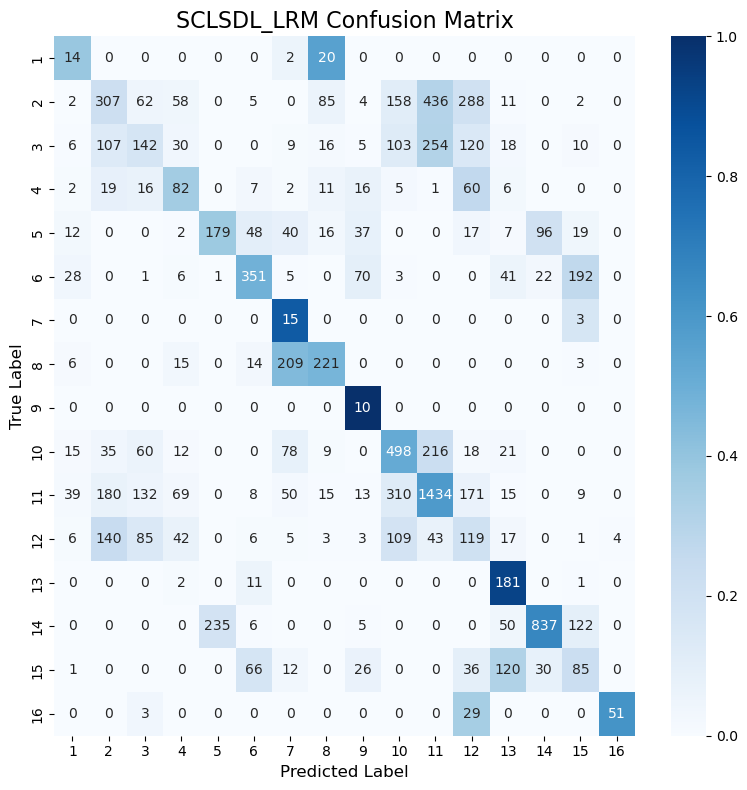

Classification Accuracy: 44.86%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


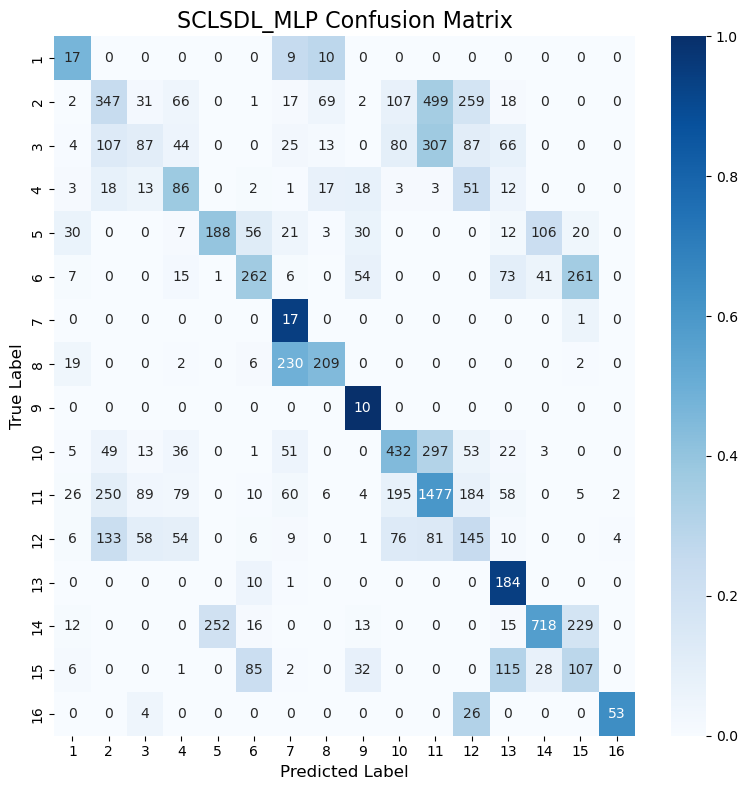

Classification Accuracy: 43.01%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          48.31
1    LRM (CAE)          44.65
2    MLP (CAE)          41.14
3     TSCL LRM          45.67
4     TSCL MLP          45.45
5  SCL_SDL LRM          44.86
6  SCL_SDL MLP          43.01

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          48.31
3     TSCL LRM          45.67
4     TSCL MLP          45.45
5  SCL_SDL LRM          44.86
1    LRM (CAE)          44.65
6  SCL_SDL MLP          43.01
2    MLP (CAE)          41.14
